In [1]:
import time
import numpy as np
import itertools
import math
import copy
from functools import reduce # python3 compatibility
from operator import mul
import json

In [2]:
# Functions for generating environment with capability
# generating task
def gen_tasks(task_num, max_capNum, capabilities): # n is the number of task, max_capNum is the maximum number of cap a task could require
    return [sorted(np.random.choice(capabilities, np.random.randint(1, max_capNum+1),replace=False)) for j in range(0, task_num)]


def gen_constraints(agent_num, task_num, power=1, a_min_edge=2,
                    t_max_edge=5):  # power is the inforce you put in the probabilities

    # the maximum tasks an agent could work on depends on the number of tasks available (e.g, if |T| = 1/2|A|, the roughly each agent can work on two tasks)
    # calculate the max and min edges for agents
    seats = math.floor(t_max_edge * task_num)
    a_taskInds = [[] for i in range(0, agent_num)]
    t_counter = [0 for j in range(0, task_num)]  # each indicate the current number of agents on the task

    ## generating the number of tasks the agents could work on.
    a_taskNums = []
    for i in range(0, agent_num):
        a_max_edge = min((seats - (agent_num - 1 - i) * a_min_edge), t_max_edge)
        a_min_edge = min(a_min_edge, a_max_edge)
        a_taskNums.append(
            np.random.randint(a_min_edge, a_max_edge + 1))  # indicate the number of task the agent could work on
        seats -= a_taskNums[i]

    t_indexes = [j for j in range(0, task_num) if
                 t_counter[j] < t_max_edge]  # make sure no further draw for those reached the maximum limit.
    for i in range(0, agent_num):
        if any([tc == 0 for tc in t_counter]):
            t_prob = [(math.e ** (t_max_edge - t_counter[j])) ** power for j in
                      t_indexes]  # power is used to manify the probability
            sum_prob = sum(t_prob)
            t_prop_2 = [prop / sum_prob for prop in t_prob]

            # draw tasks accounting to their current allocations
            a_taskInds[i] = list(np.random.choice(t_indexes, min(a_taskNums[i], len(t_indexes)), replace=False,
                                                  p=[prop / sum_prob for prop in t_prob]))
            # increase the chosen task counters
        else:
            a_taskInds[i] = list(np.random.choice(t_indexes, min(a_taskNums[i], len(t_indexes)), replace=False))

        for j in a_taskInds[i]:
            t_counter[j] += 1
        t_indexes = [j for j in range(0, task_num) if
                     t_counter[j] < t_max_edge]  # make sure no further draw for those reached the maximum limit.

    # get also the list of agents for each task
    t_agents = [[i for i in range(0, agent_num) if j in a_taskInds[i]] for j in range(0, task_num)]

    return a_taskInds, t_agents


def gen_agents(constraints, tasks, max_capNum, capabilities,
               max_capVal):  # m is the number of task, max_capNum is the maximum number of cap a task could require, max_capVal is the maximum capability value

    a_taskInds = constraints[0]
    agent_num = len(a_taskInds)
    caps_lists = []
    contri_lists = []
    for i in range(0, agent_num):
        t_caps = [tasks[j] for j in a_taskInds[i]]  # lists of caps that each task agent could perform

        caps_union = set(itertools.chain(*t_caps))  # union of caps of tasks that agent could perform
        a_cap_num = np.random.randint(min(3, max_capNum, len(caps_union)),
                                      min(len(caps_union), max_capNum) + 1)  # the num of caps the agent will have

        a_caps = set([np.random.choice(t_c) for t_c in
                      t_caps])  # initial draw to guarantee the agent has some contribution to each of the task that he could do

        rest_choices = list(caps_union.difference(a_caps))
        if rest_choices != []:
            # if min(len(rest_choices), a_cap_num - len(a_taskInds[i])) < 0:
            #     print("negative number a_cap_num - len(a_taskInds[i]): {}!".format(a_cap_num - len(a_taskInds[i])))
            # else:
            update_len = max(0, a_cap_num - len(a_taskInds[i]))
            a_caps.update(np.random.choice(rest_choices, min(len(rest_choices), update_len), replace=False))

        caps_lists.append(sorted(list(a_caps)))

        contri_lists.append(
            [(np.random.randint(1, max_capVal + 1) if c in caps_lists[i] else 0) for c in range(0, len(capabilities))])
    return caps_lists, contri_lists



In [3]:
def random(agents, tasks, constraints, gamma = 1):
    task_num = len(tasks)
    agent_num = len(agents)
    a_taskInds = constraints[0]
    alloc = [np.random.choice(a_taskInds[i]+[task_num]) for i in range(0,agent_num)]
    return alloc, sys_reward_agents(agents,tasks, alloc, gamma)

In [4]:
def task_reward(task, agents, gamma=1):  # task is represented by a list of capabilities it requires, agents is
    # a list of agents, where each represented by a list cap contribution values
    if agents == []:
        return 0
    else:
        return sum([max([agent[cap] for agent in agents]) for cap in task]) * (gamma ** len(agents))


def sys_reward_agents(agents, tasks, alloc, gamma=1): #alloc is a vector of size M each element indicate which task the agent is alloated to
    return sum([task_reward(tasks[j], [agents[i] for i in range(0,len(agents)) if alloc[i] == j], gamma) for j in range(0, len(tasks))])


def resultCal(agents, tasks, constraints, r_msgs, iteration, iter_over, converge, gamma=1):
    a_taskInds = constraints[0]
    agent_num = len(agents)
    task_num = len(tasks)
    a_msg_sum = [{d_key: sum([r_msgs[j][i][0] for j in a_taskInds[i] if j != d_key])
                         + r_msgs[d_key][i][1] for d_key in a_taskInds[i]}
                 for i in range(0, agent_num)]
    alloc = [max(ams, key=ams.get) if ams != {} else task_num for ams in a_msg_sum]
    return alloc, sys_reward_agents(agents, tasks, alloc, gamma), iteration, iter_over, converge


# Agent contribution
def agent_con(competency_lists, t_caps_lists, query_agentIndex, query_taskIndex, member, a_taskInds):
    # the marginal contribution of an agent to a coalition
    if query_taskIndex == len(t_caps_lists):
        return 0
    if query_taskIndex not in a_taskInds[query_agentIndex]:
        return 0
    curr_pro = [competency_lists[mem] for mem in member]
    cur_reward = task_reward(t_caps_lists[query_taskIndex], curr_pro, gamma=1)
    if query_agentIndex in member:
        remained_mems = member[:]
        remained_mems.remove(query_agentIndex)  # the remained coalition members besides of agent i
        coal_pro = [competency_lists[mem] for mem in remained_mems]
        new_reward = task_reward(t_caps_lists[query_taskIndex], coal_pro, gamma=1)
        return cur_reward - new_reward
    else:
        added_mems = member[:]
        added_mems.append(query_agentIndex)
        coal_pro = [competency_lists[mem] for mem in added_mems]
        new_reward = task_reward(t_caps_lists[query_taskIndex], coal_pro, gamma=1)
        return new_reward - cur_reward


def aim_tasks(movement_values, a_tasks, a_index):
    max_mv = max(movement_values['agent ' + str(a_index)])
    target_tasks = []  # aiming tasks are the tasks the agent makes proposal to
    max_num = movement_values['agent ' + str(a_index)].count(max_mv)
    first_pos = 0
    for ind in range(max_num):
        new_list = movement_values['agent ' + str(a_index)][first_pos:]
        index_add_t = first_pos + new_list.index(max_mv)
        act_task = a_tasks[a_index][index_add_t]
        target_tasks.append(act_task)
        next_pos = new_list.index(max_mv) + 1
        first_pos += next_pos
    return target_tasks


def accepted_tasks(instruction_received, propose_states, a_index):
    accept_num = instruction_received['agent ' + str(a_index)].count(1)
    accept_tasks = []  # the index of accept message, which corresponding to the index of sending tasks
    first_pos = 0
    for ind in range(accept_num):
        new_list = instruction_received['agent ' + str(a_index)][first_pos:]
        new_t_ind = first_pos + new_list.index(1)
        act_task = propose_states['agent ' + str(a_index)][new_t_ind]
        accept_tasks.append(act_task)
        next_pos = new_list.index(1) + 1
        first_pos += next_pos
    return accept_tasks



In [5]:
def OPD(agents, tasks, constraints, gamma):
    task_num = len(tasks)
    agent_num = len(agents)
    a_taskInds = [list(con) for con in constraints[0]]
    t_agentInds = [list(con) for con in constraints[1]]

    a_ubs = [[0 for j in a_taskInds[i]] for i in range(0, agent_num)]
    a_lbs = [[0 for j in a_taskInds[i]] for i in range(0, agent_num)]

    for j in range(0, task_num):

        linked_agentInds = t_agentInds[j]
        com_dict = []
        com_rewards = []
        for c in itertools.product(*[[0, 1] for i in linked_agentInds]):
            com_dict.append({linked_agentInds[i]: c[i] for i in range(0, len(c))})
            com_rewards.append(
                task_reward(tasks[j], [agents[a_key] for a_key in com_dict[-1].keys() if com_dict[-1][a_key] == 1],
                            gamma)
            )

        for i in t_agentInds[j]:
            t_ind = a_taskInds[i].index(j)
            cons_j = [com_rewards[c]
                      for c in range(0, len(com_dict)) if com_dict[c][i] == 1]

            a_lbs[i][t_ind] = min(cons_j)
            a_ubs[i][t_ind] = max(cons_j)

    for i in range(0, agent_num):
        t_flag = [True for j in a_taskInds[i]]
        for t_ind in range(0, len(a_taskInds[i])):
            for t2_ind in range(0, len(a_taskInds[i])):
                if t_ind != t2_ind and a_ubs[i][t_ind] < a_lbs[i][t2_ind]:
                    t_flag[t_ind] = False
                    break

        for t_ind in range(0, len(t_flag)):
            if not t_flag[t_ind]:
                t_agentInds[a_taskInds[i][t_ind]].remove(i)

        new_a_taskInds = [a_taskInds[i][t_ind]
                          for t_ind in range(0, len(a_taskInds[i])) if t_flag[t_ind]]
        a_taskInds[i] = new_a_taskInds

    return a_taskInds, t_agentInds


def FMS(agents, tasks, constraints, gamma, time_bound):
    converge = False
    iter_over = False
    start_time = time.time()
    a_taskInds = constraints[0]
    t_agentInds = constraints[1]
    task_num = len(tasks)
    agent_num = len(agents)

    q_msgs = [{t_key: {} for t_key in a_taskInds[i]} for i in range(0, agent_num)]
    r_msgs = [
        {t_agentInds[j][i]: ({1: -100} if len(a_taskInds[t_agentInds[j][i]]) == 1 else {key: -100 for key in [0, 1]})
         for i in range(0, len(t_agentInds[j]))}
        for j in range(0, task_num)]

    q_flags = [False for i in range(0, agent_num)]
    r_flags = [False for j in range(0, task_num)]

    iteration = 0
    while iteration < agent_num + task_num:  # True:
        if time.time() - start_time >= time_bound:
            return resultCal(agents, tasks, constraints, r_msgs, iteration, iter_over, converge, gamma)
        iteration += 1

        if iteration > agent_num + task_num:
            iter_over = True
            return resultCal(agents, tasks, constraints, r_msgs, iteration, iter_over, converge, gamma)

        if all(q_flags) and all(r_flags):  # converge, msgs are all the same.
            converge = True
            # break
        for i in range(0, agent_num):
            linked_taskInds = a_taskInds[i]

            flag = True
            for t_key in linked_taskInds:

                ####### check time bound
                if time.time() - start_time >= time_bound:
                    return resultCal(agents, tasks, constraints, r_msgs, iteration, iter_over, converge, gamma)
                ####### check time bound
                msgs = {}

                if len(linked_taskInds) > 1:
                    msgs[1] = sum([m[0] for m in [r_msgs[j][i] for j in linked_taskInds if j != t_key]])
                    msg_0 = []
                    ts = list(linked_taskInds)
                    ts.remove(t_key)

                    for k in ts:
                        msg_0.append(sum([m[0] for m in [r_msgs[j][i] for j in ts if j != k]])
                                     + r_msgs[k][i][1])

                    msgs[0] = (0 if msg_0 == [] else max(msg_0))
                else:
                    msgs[1] = 0

                alphas = -sum(msgs.values()) / len(msgs.keys())

                msgs_regularised = {d_key: msgs[d_key] + alphas for d_key in msgs.keys()}

                old_msg = q_msgs[i][t_key]
                if old_msg != {} and any([abs(msgs_regularised[d_key] - old_msg[d_key]) > 10 ** (-5)
                                          for d_key in old_msg.keys()]):
                    flag = False

                q_msgs[i][t_key] = msgs_regularised

            if flag:  # agent i sending the same info
                q_flags[i] = True

        if time.time() - start_time >= time_bound:
            break
        ###################### SAME thing, using comprehension
        #             msgs = {t_key:{d_key:sum([m[d_key] for m in [r_msgs[j][i] for j in linked_taskInds if j != t_key]])
        #                            for d_key in linked_taskInds}
        #                                 for t_key in linked_taskInds}
        #             alphas = {t_key:-sum(msgs[t_key].values())/len(msgs.keys())
        #                       for t_key in linked_taskInds}
        #             msgs_regularised = {t_key:{d_key:msgs[t_key][d_key] + alphas[t_key]
        #                            for d_key in linked_taskInds}
        #                                 for t_key in linked_taskInds}
        for j in range(0, task_num):
            linked_agentInds = t_agentInds[j]
            # msg_con = [q_msgs[a][j] for a in linked_agentInds]

            com_dict = []
            com_rewards = []
            dom_com = [[0, 1] if len(a_taskInds[i]) > 1 else [1] for i in linked_agentInds]

            for c in itertools.product(*dom_com):
                ####### check time bound
                if time.time() - start_time >= time_bound:
                    return resultCal(agents, tasks, constraints, r_msgs, iteration, iter_over, converge, gamma)
                ####### check time bound

                com_dict.append({linked_agentInds[i]: c[i] for i in range(0, len(c))})
                com_rewards.append(
                    task_reward(tasks[j], [agents[a_key] for a_key in com_dict[-1].keys() if com_dict[-1][a_key] == 1],
                                gamma)
                )

            flag = True
            for a_key in linked_agentInds:

                ####### check time bound
                if time.time() - start_time >= time_bound:
                    return resultCal(agents, tasks, constraints, r_msgs, iteration, iter_over, converge, gamma)
                ####### check time bound

                old_msg = r_msgs[j][a_key]
                q_table = []
                for c in range(0, len(com_dict)):
                    q_table.append(sum([q_msgs[a][j][com_dict[c][a]] for a in linked_agentInds if a != a_key])
                                   + com_rewards[c])

                r_msgs[j][a_key] = {
                    d_key: max([q_table[c] for c in range(0, len(com_dict)) if com_dict[c][a_key] == d_key])
                    for d_key in ([0, 1] if len(a_taskInds[a_key]) > 1 else [1])}

                if any([abs(r_msgs[j][a_key][d_key] - old_msg[d_key]) > 10 ** (-5) for d_key in old_msg.keys()]):
                    flag = False

            if flag:  # task j sending the same info
                r_flags[j] = True

    return resultCal(agents, tasks, constraints, r_msgs, iteration, iter_over, converge, gamma)


In [6]:
def embed_DSA(a_tasks, t_agents, tasks, agents, probability, time_bound):
    converge = False
    agent_num = len(agents)
    task_num = len(tasks)

    received_contribution = {} # zero at the task_num-th is the contribution of an agent assigned to no tasks
    for i in range(0, agent_num):
        received_contribution['agent ' + str(i)] = list(np.zeros(len(a_tasks[i]), int))
    movement_values = {}
    CS = [[] for j in range(0, task_num + 1)]
    CS[task_num] = list(range(0, agent_num))
    state = [task_num for i in range(0, agent_num)]
    update_t = range(0, task_num)
    iter = 0
    message_pass_num = 0
    is_continue = True
    start_time = time.time()
    while is_continue:  # > 0:
        if time.time() - start_time >= time_bound:
            break
        iter += 1

        # update agents' allocation state
        for j in range(0, task_num):
            member_agents = CS[j]
            for i in member_agents:
                state[i] = int(j)

        # tasks calculate agents contribution to them
        for j in range(0, task_num):
            if j in update_t:
                for i in t_agents[j]:
                    message_pass_num += 1
                    j_index = a_tasks[i].index(j)
                    received_contribution['agent ' + str(i)][j_index] = agent_con(agents, tasks, i, j, CS[j], a_tasks)

        # agents calculate their movement values #
        for i in range(0, agent_num):
            current_task = state[i]   # the agent's current task
            if current_task == task_num:
                current_contribution = 0
            else:
                cur_t_ind = a_tasks[i].index(current_task)
                current_contribution = received_contribution['agent ' + str(i)][cur_t_ind]
            movement_values['agent ' + str(i)] = [received_contribution['agent ' + str(i)][mess_ind]-current_contribution for mess_ind in range(0, len(received_contribution['agent ' + str(i)]))]

        # agents choose their tasks  ##########
        update_t = []
        max_mv = [[] for i in range(0, agent_num)]
        for i in range(0, agent_num):
            max_mv[i] = max(movement_values['agent ' + str(i)])
            if max_mv[i] > 0:
                pro = np.random.random(1)
                if pro > 1 - probability:
                    old_task = state[i]
                    potential_task = aim_tasks(movement_values, a_tasks, i)
                    choosed_task = np.random.choice(potential_task)
                    CS[choosed_task].append(i)
                    update_t.append(choosed_task)
                    state[i] = choosed_task
                    CS[old_task].remove(i)
                    update_t.append(old_task)
        #  if continue
        if max(max_mv) > 0:
            is_continue = True
        else:
            is_continue = False
            converge = True

    #  current system reward    #
    global_u = sys_reward_agents(agents, tasks, state, gamma=1)

    return global_u, iter, message_pass_num, converge


In [7]:
def embed_disNE(a_tasks, t_agents, tasks, agents, time_bound, CS=[]):
    converge = False
    agent_num = len(agents)
    task_num = len(tasks)
    if CS== []:  # start from scratch
        CS = [[] for j in range(0, task_num + 1)]  # current coalition structure, the last one is dummy coalition
        CS[task_num] = list(range(0, agent_num))
    state = [task_num for i in range(0, agent_num)]  # agents' current assignments, initially are no-task (task_num)
    
    received_contribution = {}  # zero at the task_num-th is the contribution of an agent assigned to no tasks
    for i in range(0, agent_num):
        received_contribution['agent ' + str(i)] = list(np.zeros(len(a_tasks[i]), int))

    movement_values = {}

    
    iter = 0
    update_t = range(0, task_num)
    message_pass_num = 0
    is_continue = True
    start_time = time.time()
    while is_continue:  # > 0:
        if time.time() - start_time >= time_bound:
            break
        iter += 1
        # update agents' allocation state
        for j in update_t:
            member_agents = CS[j]
            for i in member_agents:
                state[i] = int(j)

        # tasks calculate agents contribution to them
        for j in range(0, task_num):
            if j in update_t:
                for i in t_agents[j]:
                    message_pass_num += 1
                    j_index = a_tasks[i].index(j)
                    received_contribution['agent ' + str(i)][j_index] = agent_con(agents, tasks, i, j, CS[j], a_tasks)

        # agents calculate their movement values #
        for i in range(0, agent_num):
            current_task = state[i]   # the agent's current task
            if current_task == task_num:
                current_contribution = 0
            else:
                cur_t_ind = a_tasks[i].index(current_task)
                current_contribution = received_contribution['agent ' + str(i)][cur_t_ind]
            movement_values['agent ' + str(i)] = [received_contribution['agent ' + str(i)][mess_ind]-current_contribution for mess_ind in range(0, len(received_contribution['agent ' + str(i)]))]

        #   agents propose to tasks #
        received_proposal = [{'from agents': [], 'proposal values': []} for j in range(0, task_num)]   # the proposals received by tasks
        propose_states = {}    # which agents propose to which tasks
        propose_agents = []     # which agents make proposals
        received_tasks = []  # which tasks receive proposals
        max_mv = [[] for i in range(0, agent_num)]
        for i in range(0, agent_num):
            max_mv[i] = max(movement_values['agent ' + str(i)])
            if max(movement_values['agent ' + str(i)]) > 0:
                propose_agents.append(i)
                aim_task = aim_tasks(movement_values, a_tasks, i)
                old_task = state[i]
                if old_task != task_num:
                    aim_task.append(old_task)
                message_pass_num += len(aim_task)
                propose_states['agent ' + str(i)] = aim_task
                received_tasks.append(aim_task)
                for j in aim_task:
                    received_proposal[j]['from agents'].append(i)
                    received_proposal[j]['proposal values'].append(max_mv[i])

        # check whether or not to continue  #
        if max(max_mv) > 0:
            is_continue = True
        else:
            is_continue = False
            converge = True

        # tasks send instruction messages to agents #
        if is_continue:
            #  find out which coalitions received proposal
            active_tasks = []
            for j in received_tasks:
                active_tasks.extend(j)
            active_tasks = list(set(active_tasks))

            instruction_received = {}
            for i in propose_agents:
                instruction_received['agent ' + str(i)] = list(np.zeros(len(propose_states['agent ' + str(i)]), int))
                message_pass_num += len(propose_states['agent ' + str(i)])

            for j in active_tasks:
                if j == task_num:
                    for a_i in received_proposal[j]['from agents']:
                        a_i_index = propose_states['agent ' + str(int(a_i))].index(j)
                        instruction_received['agent ' + str(int(a_i))][a_i_index] = 1
                else:
                    max_pro = max(received_proposal[j]['proposal values'])
                    index_add_a = received_proposal[j]['proposal values'].index(max_pro)
                    choosed_agent = received_proposal[j]['from agents'][index_add_a]
                    acc_t_ind = propose_states['agent '+ str(int(choosed_agent))].index(j)   # the index of task j
                    instruction_received['agent '+str(int(choosed_agent))][acc_t_ind] = 1

        # agents move to tasks
        update_t = []
        for i in propose_agents:
            # accept_num = instruction_received['agent '+str(i)].count(1)
            if instruction_received['agent '+str(i)].count(1) == 0:
                continue
            else:
                accept_tasks = accepted_tasks(instruction_received, propose_states, i)
                old_coa = state[i]
                if old_coa != task_num:
                    old_coa_ind = propose_states['agent '+ str(i)].index(old_coa)
                    if instruction_received['agent '+str(i)][old_coa_ind] == 0:  # agent's own task reject its movement
                        continue
                    else:
                        message_pass_num += 1
                        accept_tasks.remove(old_coa)  # the other accept-coalitions besides its own coalition
                if len(accept_tasks) == 0:
                    continue
                else:
                    message_pass_num += 1
                    choosed_task = np.random.choice(accept_tasks)  # random select a coalition that gives accept message
                CS[choosed_task].append(i)
                update_t.append(choosed_task)
                de_i_ind = CS[old_coa].index(i)
                del CS[old_coa][de_i_ind]
                update_t.append(old_coa)

    # current system reward #
    global_u = sys_reward_agents(agents, tasks, state, gamma=1)
    return global_u, iter, message_pass_num, converge


In [8]:
def append_record(record, filename, typ):
    with open(filename, 'a') as f:
        if typ != '':
            json.dump(record, f, default = typ)
        else:
            json.dump(record, f)
        f.write('\n')
        # f.write(os.linesep)
        f.close()

In [10]:
run_num = 88
probability = 0.7
time_bound = 300
max_t_num = 1000
capNum = 10
max_capNum_task = 10
max_capNum_agent = 10
max_capVal = 10
capabilities = list(range(0, capNum))
a_min_edge = 1
min_t_num = 100
ex_identifier = 120

# t_max_edge = 6
# min_t_num = 2
# max_t_num = 2
# agent_num = 4
# agents = np.array([[0, 0, 0, 7, 6], [4, 3, 8, 8, 4], [0, 9, 8, 0, 0], [4, 9, 0, 7, 0]])
# tasks = np.array([[0, 1, 2], [0, 3, 4]])
# constraints = ([[0, 1], [0, 1], [0, 1], [0, 1]], [[0, 1, 2, 3], [0, 1, 2, 3]])

# compare algorithms
for run in range(0, run_num):
    print('run:', run)
    task_num = min_t_num
    while task_num <= max_t_num:
        t_max_edge = 0.04 * task_num
        ex_identifier += 1
        agent_num = 2 * task_num
        tasks = gen_tasks(task_num, max_capNum_task, capabilities)

        constraints = gen_constraints(agent_num, task_num, 1, a_min_edge, t_max_edge)
        ## caps_lists: capabilities the agent can provide; agents: the value of the agent provide the capabilities
        caps_lists, agents = gen_agents(constraints, tasks, max_capNum_agent, capabilities, max_capVal)

        a_tasks = constraints[0]
        t_agents = constraints[1]
        for i in range(0, agent_num):
            a_tasks[i].append(task_num)
        t_agents.append(list(range(0, agent_num)))

        result = {"ex_identifier": ex_identifier, "task_num": task_num, "agent_num": agent_num}

        if t_max_edge <= 17:
            start = time.time()
            new_con = OPD(agents, tasks, constraints, gamma=1)
            r = FMS(agents, tasks, new_con, gamma=1, time_bound=time_bound)
            end = time.time()
            result['BnBFMS_u'] = r[1]
            result['BnBFMS_t'] = end - start
            result['BnBFMS_iter'] = r[2]
            result['BnBFMS_converge'] = r[4]
            print("task_number: ", task_num, "BnBFMS time:", result['BnBFMS_t'], 'result:', result['BnBFMS_u'],
                  "iteration:", result['BnBFMS_iter'], "converge?", result['BnBFMS_converge'])
            print()
        
        r = random(agents, tasks,constraints, gamma=1 )
        alloc = r[0]
        result['rand'] = r[1]
        print("task_number: ", task_num, 'rand result',result['rand'])
        rand_CS = [[] for i in list(range(0, task_num + 1))]
        for i in list(range(0, agent_num)):
            rand_CS[alloc[i]].append(i)


         ##  DSA
        start = time.time()
        dsa_u, dsa_iter, dsa_msg_num, if_converge = embed_DSA(a_tasks, t_agents, tasks, agents, probability, time_bound)
        end = time.time()
        result['dsa_u'] = dsa_u
        result['dsa_t'] = end-start
        result['dsa_iter'] = dsa_iter
        result['dsa_msg'] = dsa_msg_num
        result['DSA_converge'] = if_converge
        print("task_number: ", task_num, "DSA time:", result['dsa_t'], 'result:', result['dsa_u'],
              "iteration:", result['dsa_iter'], "messages", result['dsa_msg'], "converge?", result['DSA_converge'])
        print()
        
        ##  DisNE starts from a random solution
        rand_disne = copy.deepcopy(rand_CS) 
        start = time.time()
        [LS_u, LS_iter, LS_msg_num, if_converge] = embed_disNE(a_tasks, t_agents, tasks, agents, time_bound, rand_disne)
        end = time.time()
        result['LS_u'] = LS_u
        result['LS_t'] = end - start
        result['LS_iter'] = LS_iter
        result['LS_msg_num'] = LS_msg_num
        result['LS_converge'] = if_converge
        print("task number: ", task_num, "LS_t:", result['LS_t'], 'LS_u:', LS_u,
                "LS_iter:", LS_iter, "messages", result['LS_msg_num'], "converge?", result['LS_converge'])
        print()

        start = time.time()
        disNE_u, disNE_iter, disNE_msg_num, if_converge = embed_disNE(a_tasks, t_agents, tasks, agents, time_bound, [])
        end = time.time()
        result['disNE_u'] = disNE_u
        result['disNE_t'] = end-start
        result['disNE_iter'] = disNE_iter
        result['DisNE_msg'] = disNE_msg_num
        result['DisNE_converge'] = if_converge
        print("task_number: ", task_num, "disNE time:", result['disNE_t'],'result:', result['disNE_u'],
              "iteration:", result['disNE_iter'], "messages", result['DisNE_msg'], "converge?", result['DisNE_converge'])
        print()

#         append data and result
        files = {'general_cap_thesis': [result, '']} #
        for filename in list(files.keys()):
            append_record(files[filename][0], filename, typ=files[filename][1])

        # increase the task_number
        task_num += 100
    run += 1




run: 0
task_number:  100 BnBFMS time: 3.3480045795440674 result: 3363 iteration: 300 converge? True

task_number:  100 rand result 1574
task_number:  100 DSA time: 0.03590726852416992 result: 3420 iteration: 11 messages 1332 converge? True

task number:  100 LS_t: 0.02987980842590332 LS_u: 3409 LS_iter: 7 messages 1991 converge? True

task_number:  100 disNE time: 0.03191518783569336 result: 3408 iteration: 7 messages 2096 converge? True

task_number:  200 BnBFMS time: 300.500417470932 result: 7767 iteration: 313 converge? True

task_number:  200 rand result 3774
task_number:  200 DSA time: 0.3520638942718506 result: 7800 iteration: 35 messages 13568 converge? True

task number:  200 LS_t: 0.11768770217895508 LS_u: 7660 LS_iter: 10 messages 8004 converge? True

task_number:  200 disNE time: 0.12170076370239258 result: 7745 iteration: 8 messages 7542 converge? True

task_number:  300 BnBFMS time: 316.16449213027954 result: 11357 iteration: 7 converge? False

task_number:  300 rand resul

task_number:  200 BnBFMS time: 300.75534558296204 result: 7364 iteration: 309 converge? False

task_number:  200 rand result 3602
task_number:  200 DSA time: 0.24334955215454102 result: 7475 iteration: 22 messages 9352 converge? True

task number:  200 LS_t: 0.14461374282836914 LS_u: 7370 LS_iter: 12 messages 8248 converge? True

task_number:  200 disNE time: 0.1326451301574707 result: 7408 iteration: 9 messages 7668 converge? True

task_number:  300 BnBFMS time: 317.2539210319519 result: 11665 iteration: 6 converge? False

task_number:  300 rand result 6878
task_number:  300 DSA time: 1.5179753303527832 result: 12364 iteration: 61 messages 59748 converge? True

task number:  300 LS_t: 0.3241465091705322 LS_u: 12092 LS_iter: 16 messages 17848 converge? True

task_number:  300 disNE time: 0.27128076553344727 result: 12161 iteration: 9 messages 15596 converge? True

task_number:  400 BnBFMS time: 788.8454542160034 result: 12514 iteration: 1 converge? False

task_number:  400 rand result 

task_number:  300 BnBFMS time: 316.78932785987854 result: 11009 iteration: 7 converge? False

task_number:  300 rand result 6288
task_number:  300 DSA time: 1.5406057834625244 result: 11696 iteration: 68 messages 61404 converge? True

task number:  300 LS_t: 0.2872323989868164 LS_u: 11448 LS_iter: 11 messages 17858 converge? True

task_number:  300 disNE time: 0.2672863006591797 result: 11578 iteration: 8 messages 15730 converge? True

task_number:  400 BnBFMS time: 714.2716417312622 result: 12041 iteration: 1 converge? False

task_number:  400 rand result 8854
task_number:  400 DSA time: 300.11830163002014 result: 13639 iteration: 3713 messages 12517936 converge? False

task number:  400 LS_t: 0.5373110771179199 LS_u: 15910 LS_iter: 14 messages 32602 converge? True

task_number:  400 disNE time: 0.500662088394165 result: 16105 iteration: 9 messages 26978 converge? True

task_number:  500 rand result 11378
task_number:  500 DSA time: 300.15093183517456 result: 16808 iteration: 2242 mes

task_number:  400 BnBFMS time: 742.8774607181549 result: 12070 iteration: 1 converge? False

task_number:  400 rand result 8737
task_number:  400 DSA time: 300.1330831050873 result: 13944 iteration: 3500 messages 11152256 converge? False

task number:  400 LS_t: 0.801044225692749 LS_u: 15680 LS_iter: 14 messages 31406 converge? True

task_number:  400 disNE time: 0.805161714553833 result: 15976 iteration: 10 messages 27203 converge? True

task_number:  500 rand result 11938
task_number:  500 DSA time: 300.1520872116089 result: 17028 iteration: 2185 messages 12395920 converge? False

task number:  500 LS_t: 0.807847261428833 LS_u: 20666 LS_iter: 15 messages 47492 converge? True

task_number:  500 disNE time: 0.7789220809936523 result: 20924 iteration: 12 messages 41821 converge? True

task_number:  600 rand result 15666
task_number:  600 DSA time: 300.2579083442688 result: 19735 iteration: 1400 messages 11969952 converge? False

task number:  600 LS_t: 1.2935559749603271 LS_u: 25760 LS_

task_number:  500 rand result 12082
task_number:  500 DSA time: 300.15397548675537 result: 17254 iteration: 2188 messages 12260560 converge? False

task number:  500 LS_t: 0.7689554691314697 LS_u: 20334 LS_iter: 14 messages 45472 converge? True

task_number:  500 disNE time: 0.7589871883392334 result: 20734 iteration: 11 messages 40901 converge? True

task_number:  600 rand result 15684
task_number:  600 DSA time: 300.1614291667938 result: 20352 iteration: 1432 messages 12517185 converge? False

task number:  600 LS_t: 1.1629106998443604 LS_u: 25643 LS_iter: 15 messages 67271 converge? True

task_number:  600 disNE time: 1.128981351852417 result: 26008 iteration: 11 messages 60462 converge? True

task_number:  700 rand result 18635
task_number:  700 DSA time: 300.2691812515259 result: 22656 iteration: 1039 messages 11838036 converge? False

task number:  700 LS_t: 1.9448268413543701 LS_u: 30308 LS_iter: 20 messages 95271 converge? True

task_number:  700 disNE time: 1.636641025543213 r

task number:  600 LS_t: 1.25166916847229 LS_u: 24938 LS_iter: 19 messages 70325 converge? True

task_number:  600 disNE time: 1.1499502658843994 result: 25296 iteration: 14 messages 58692 converge? True

task_number:  700 rand result 19121
task_number:  700 DSA time: 300.38856959342957 result: 23378 iteration: 1084 messages 12365164 converge? False

task number:  700 LS_t: 1.5788025856018066 LS_u: 30819 LS_iter: 17 messages 90216 converge? True

task_number:  700 disNE time: 1.6077167987823486 result: 31319 iteration: 13 messages 81196 converge? True

task_number:  800 rand result 21085
task_number:  800 DSA time: 300.284396648407 result: 26130 iteration: 808 messages 12115072 converge? False

task number:  800 LS_t: 2.2360522747039795 LS_u: 34713 LS_iter: 18 messages 123782 converge? True

task_number:  800 disNE time: 2.0984182357788086 result: 35304 iteration: 12 messages 102541 converge? True

task_number:  900 rand result 24629
task_number:  900 DSA time: 300.530193567276 result: 

task_number:  700 disNE time: 1.5508842468261719 result: 30324 iteration: 13 messages 78151 converge? True

task_number:  800 rand result 21662
task_number:  800 DSA time: 300.25082755088806 result: 25228 iteration: 824 messages 11966880 converge? False

task number:  800 LS_t: 2.169241189956665 LS_u: 34538 LS_iter: 18 messages 118089 converge? True

task_number:  800 disNE time: 2.1862049102783203 result: 35106 iteration: 16 messages 103988 converge? True

task_number:  900 rand result 25251
task_number:  900 DSA time: 300.38882422447205 result: 28453 iteration: 642 messages 11486556 converge? False

task number:  900 LS_t: 2.8594038486480713 LS_u: 39867 LS_iter: 19 messages 150620 converge? True

task_number:  900 disNE time: 2.6369948387145996 result: 40519 iteration: 13 messages 127631 converge? True

task_number:  1000 rand result 28432
task_number:  1000 DSA time: 300.76582384109497 result: 31779 iteration: 514 messages 11294384 converge? False

task number:  1000 LS_t: 3.5764994

task_number:  900 rand result 25098
task_number:  900 DSA time: 300.3787543773651 result: 28722 iteration: 640 messages 11614176 converge? False

task number:  900 LS_t: 2.717740774154663 LS_u: 39355 LS_iter: 17 messages 145846 converge? True

task_number:  900 disNE time: 2.677853584289551 result: 40034 iteration: 12 messages 128202 converge? True

task_number:  1000 rand result 28212
task_number:  1000 DSA time: 300.4588825702667 result: 31651 iteration: 514 messages 11098200 converge? False

task number:  1000 LS_t: 3.5894112586975098 LS_u: 44692 LS_iter: 19 messages 187281 converge? True

task_number:  1000 disNE time: 3.3690075874328613 result: 45532 iteration: 13 messages 158367 converge? True

run: 15
task_number:  100 BnBFMS time: 3.2473244667053223 result: 3376 iteration: 300 converge? True

task_number:  100 rand result 1584
task_number:  100 DSA time: 0.05086350440979004 result: 3419 iteration: 22 messages 1428 converge? True

task number:  100 LS_t: 0.0249330997467041 LS_u:

task number:  1000 LS_t: 3.5206074714660645 LS_u: 44508 LS_iter: 19 messages 179045 converge? True

task_number:  1000 disNE time: 3.369006872177124 result: 45352 iteration: 14 messages 157577 converge? True

run: 17
task_number:  100 BnBFMS time: 3.421813726425171 result: 3521 iteration: 300 converge? True

task_number:  100 rand result 1746
task_number:  100 DSA time: 0.028922557830810547 result: 3544 iteration: 8 messages 1200 converge? True

task number:  100 LS_t: 0.025928735733032227 LS_u: 3555 LS_iter: 6 messages 1945 converge? True

task_number:  100 disNE time: 0.03191494941711426 result: 3540 iteration: 7 messages 2241 converge? True

task_number:  200 BnBFMS time: 300.48065996170044 result: 7435 iteration: 406 converge? False

task_number:  200 rand result 3925
task_number:  200 DSA time: 0.2972066402435303 result: 7603 iteration: 31 messages 11376 converge? True

task number:  200 LS_t: 0.11170029640197754 LS_u: 7505 LS_iter: 9 messages 8037 converge? True

task_number:  20

task_number:  200 BnBFMS time: 300.4805543422699 result: 7288 iteration: 358 converge? False

task_number:  200 rand result 3324
task_number:  200 DSA time: 0.2672851085662842 result: 7359 iteration: 26 messages 10608 converge? True

task number:  200 LS_t: 0.12466669082641602 LS_u: 7300 LS_iter: 11 messages 8513 converge? True

task_number:  200 disNE time: 0.12566494941711426 result: 7353 iteration: 11 messages 7406 converge? True

task_number:  300 BnBFMS time: 315.0184893608093 result: 11394 iteration: 8 converge? False

task_number:  300 rand result 6437
task_number:  300 DSA time: 1.8091678619384766 result: 12043 iteration: 73 messages 74976 converge? True

task number:  300 LS_t: 0.30219149589538574 LS_u: 11784 LS_iter: 12 messages 17662 converge? True

task_number:  300 disNE time: 0.2752647399902344 result: 11922 iteration: 9 messages 16486 converge? True

task_number:  400 BnBFMS time: 694.4042778015137 result: 12288 iteration: 1 converge? False

task_number:  400 rand result

task_number:  300 BnBFMS time: 314.7023825645447 result: 11240 iteration: 8 converge? False

task_number:  300 rand result 6205
task_number:  300 DSA time: 2.5542025566101074 result: 11758 iteration: 93 messages 102816 converge? True

task number:  300 LS_t: 0.30219531059265137 LS_u: 11513 LS_iter: 14 messages 18194 converge? True

task_number:  300 disNE time: 0.30119872093200684 result: 11620 iteration: 11 messages 16413 converge? True

task_number:  400 BnBFMS time: 688.1054708957672 result: 11998 iteration: 1 converge? False

task_number:  400 rand result 8387
task_number:  400 DSA time: 300.06156301498413 result: 13414 iteration: 4093 messages 13155072 converge? False

task number:  400 LS_t: 0.5176208019256592 LS_u: 15472 LS_iter: 14 messages 32775 converge? True

task_number:  400 disNE time: 0.5186994075775146 result: 15680 iteration: 10 messages 27204 converge? True

task_number:  500 rand result 11658
task_number:  500 DSA time: 300.14828991889954 result: 16842 iteration: 228

task_number:  400 BnBFMS time: 693.2179272174835 result: 12078 iteration: 1 converge? False

task_number:  400 rand result 8852
task_number:  400 DSA time: 300.05038499832153 result: 14210 iteration: 4112 messages 13201936 converge? False

task number:  400 LS_t: 0.52459716796875 LS_u: 15770 LS_iter: 15 messages 31477 converge? True

task_number:  400 disNE time: 0.5166196823120117 result: 15997 iteration: 11 messages 27402 converge? True

task_number:  500 rand result 12000
task_number:  500 DSA time: 300.1414837837219 result: 17008 iteration: 2278 messages 13234820 converge? False

task number:  500 LS_t: 0.8836379051208496 LS_u: 20509 LS_iter: 20 messages 47844 converge? True

task_number:  500 disNE time: 0.7649548053741455 result: 20843 iteration: 11 messages 41798 converge? True

task_number:  600 rand result 15150
task_number:  600 DSA time: 300.20507073402405 result: 20335 iteration: 1514 messages 12742056 converge? False

task number:  600 LS_t: 1.2566478252410889 LS_u: 25554 

task_number:  500 rand result 11842
task_number:  500 DSA time: 300.14054799079895 result: 17143 iteration: 2022 messages 11617520 converge? False

task number:  500 LS_t: 0.95046067237854 LS_u: 20691 LS_iter: 15 messages 50197 converge? True

task_number:  500 disNE time: 0.9325194358825684 result: 20960 iteration: 12 messages 42810 converge? True

task_number:  600 rand result 15006
task_number:  600 DSA time: 300.17841720581055 result: 19474 iteration: 1249 messages 10502088 converge? False

task number:  600 LS_t: 1.377335786819458 LS_u: 25128 LS_iter: 17 messages 70719 converge? True

task_number:  600 disNE time: 1.2995450496673584 result: 25578 iteration: 13 messages 60084 converge? True

task_number:  700 rand result 18249
task_number:  700 DSA time: 300.2451250553131 result: 22312 iteration: 904 messages 10417400 converge? False

task number:  700 LS_t: 1.7084529399871826 LS_u: 29421 LS_iter: 17 messages 93129 converge? True

task_number:  700 disNE time: 1.6047279834747314 re

task number:  600 LS_t: 1.269608497619629 LS_u: 25586 LS_iter: 17 messages 71560 converge? True

task_number:  600 disNE time: 1.3304450511932373 result: 26012 iteration: 14 messages 59305 converge? True

task_number:  700 rand result 17795
task_number:  700 DSA time: 300.16976284980774 result: 23591 iteration: 1027 messages 11380600 converge? False

task number:  700 LS_t: 1.7822644710540771 LS_u: 29849 LS_iter: 19 messages 96316 converge? True

task_number:  700 disNE time: 1.7933273315429688 result: 30287 iteration: 14 messages 81167 converge? True

task_number:  800 rand result 21070
task_number:  800 DSA time: 300.4426259994507 result: 25978 iteration: 737 messages 10747360 converge? False

task number:  800 LS_t: 2.3608665466308594 LS_u: 34348 LS_iter: 19 messages 118842 converge? True

task_number:  800 disNE time: 2.231743574142456 result: 35011 iteration: 14 messages 100212 converge? True

task_number:  900 rand result 24226
task_number:  900 DSA time: 300.6406135559082 result

task_number:  700 disNE time: 1.6099638938903809 result: 30791 iteration: 12 messages 80374 converge? True

task_number:  800 rand result 21801
task_number:  800 DSA time: 300.319011926651 result: 25300 iteration: 804 messages 11875744 converge? False

task number:  800 LS_t: 2.2142391204833984 LS_u: 34241 LS_iter: 19 messages 116706 converge? True

task_number:  800 disNE time: 2.0366926193237305 result: 34785 iteration: 10 messages 102376 converge? True

task_number:  900 rand result 25735
task_number:  900 DSA time: 300.35035157203674 result: 27934 iteration: 628 messages 11303496 converge? False

task number:  900 LS_t: 2.903346061706543 LS_u: 39454 LS_iter: 20 messages 147343 converge? True

task_number:  900 disNE time: 2.729854106903076 result: 40181 iteration: 13 messages 128800 converge? True

task_number:  1000 rand result 27263
task_number:  1000 DSA time: 300.84594321250916 result: 30689 iteration: 504 messages 11027800 converge? False

task number:  1000 LS_t: 3.7650790214

task_number:  900 rand result 25394
task_number:  900 DSA time: 300.73750472068787 result: 28830 iteration: 611 messages 10848456 converge? False

task number:  900 LS_t: 3.068845272064209 LS_u: 39974 LS_iter: 22 messages 149963 converge? True

task_number:  900 disNE time: 2.815490245819092 result: 40739 iteration: 14 messages 127480 converge? True

task_number:  1000 rand result 28638
task_number:  1000 DSA time: 300.3902425765991 result: 32103 iteration: 498 messages 10707240 converge? False

task number:  1000 LS_t: 3.8128409385681152 LS_u: 44641 LS_iter: 22 messages 183750 converge? True

task_number:  1000 disNE time: 3.404374361038208 result: 45548 iteration: 12 messages 154145 converge? True

run: 32
task_number:  100 BnBFMS time: 3.7134671211242676 result: 3774 iteration: 300 converge? True

task_number:  100 rand result 1944
task_number:  100 DSA time: 0.032944679260253906 result: 3805 iteration: 9 messages 1256 converge? True

task number:  100 LS_t: 0.029919862747192383 LS_

task number:  1000 LS_t: 3.612715721130371 LS_u: 44249 LS_iter: 19 messages 183774 converge? True

task_number:  1000 disNE time: 3.4192392826080322 result: 45126 iteration: 13 messages 156428 converge? True

run: 34
task_number:  100 BnBFMS time: 3.9334495067596436 result: 3572 iteration: 300 converge? True

task_number:  100 rand result 1729
task_number:  100 DSA time: 0.03690171241760254 result: 3582 iteration: 10 messages 1312 converge? True

task number:  100 LS_t: 0.035910606384277344 LS_u: 3561 LS_iter: 7 messages 1949 converge? True

task_number:  100 disNE time: 0.03391003608703613 result: 3587 iteration: 7 messages 2245 converge? True

task_number:  200 BnBFMS time: 300.5129728317261 result: 8181 iteration: 303 converge? False

task_number:  200 rand result 4351
task_number:  200 DSA time: 0.46376872062683105 result: 8208 iteration: 42 messages 14008 converge? True

task number:  200 LS_t: 0.12367701530456543 LS_u: 8100 LS_iter: 9 messages 7394 converge? True

task_number:  2

task_number:  200 BnBFMS time: 300.4900939464569 result: 7763 iteration: 377 converge? True

task_number:  200 rand result 3872
task_number:  200 DSA time: 0.2513303756713867 result: 7797 iteration: 23 messages 10176 converge? True

task number:  200 LS_t: 0.12627840042114258 LS_u: 7726 LS_iter: 10 messages 8456 converge? True

task_number:  200 disNE time: 0.12067699432373047 result: 7779 iteration: 7 messages 7635 converge? True

task_number:  300 BnBFMS time: 314.92896604537964 result: 11271 iteration: 8 converge? False

task_number:  300 rand result 6275
task_number:  300 DSA time: 1.7998631000518799 result: 11749 iteration: 66 messages 72564 converge? True

task number:  300 LS_t: 0.28125452995300293 LS_u: 11494 LS_iter: 11 messages 17264 converge? True

task_number:  300 disNE time: 0.2922182083129883 result: 11602 iteration: 12 messages 16185 converge? True

task_number:  400 BnBFMS time: 701.549412727356 result: 11827 iteration: 1 converge? False

task_number:  400 rand result 

task_number:  300 BnBFMS time: 315.2714259624481 result: 11488 iteration: 8 converge? False

task_number:  300 rand result 6139
task_number:  300 DSA time: 1.064880132675171 result: 12010 iteration: 35 messages 44856 converge? True

task number:  300 LS_t: 0.3031926155090332 LS_u: 11762 LS_iter: 11 messages 18637 converge? True

task_number:  300 disNE time: 0.28623270988464355 result: 11943 iteration: 10 messages 15929 converge? True

task_number:  400 BnBFMS time: 699.8619222640991 result: 11950 iteration: 1 converge? False

task_number:  400 rand result 9672
task_number:  400 DSA time: 300.0717468261719 result: 14368 iteration: 3970 messages 13086096 converge? False

task number:  400 LS_t: 0.5565142631530762 LS_u: 16049 LS_iter: 19 messages 30122 converge? True

task_number:  400 disNE time: 0.5156214237213135 result: 16273 iteration: 12 messages 28169 converge? True

task_number:  500 rand result 11911
task_number:  500 DSA time: 300.11416935920715 result: 16261 iteration: 2268 me

task_number:  400 BnBFMS time: 697.948112487793 result: 12212 iteration: 1 converge? False

task_number:  400 rand result 8702
task_number:  400 DSA time: 300.10551953315735 result: 14020 iteration: 4056 messages 13220272 converge? False

task number:  400 LS_t: 0.5275964736938477 LS_u: 15906 LS_iter: 14 messages 31736 converge? True

task_number:  400 disNE time: 0.49866795539855957 result: 16147 iteration: 11 messages 27428 converge? True

task_number:  500 rand result 12504
task_number:  500 DSA time: 300.084979057312 result: 17306 iteration: 2180 messages 12885100 converge? False

task number:  500 LS_t: 0.7749335765838623 LS_u: 21093 LS_iter: 13 messages 46803 converge? True

task_number:  500 disNE time: 0.7988717555999756 result: 21380 iteration: 10 messages 42331 converge? True

task_number:  600 rand result 15788
task_number:  600 DSA time: 300.1302511692047 result: 20689 iteration: 1502 messages 12711672 converge? False

task number:  600 LS_t: 1.2168550491333008 LS_u: 26038 

task_number:  500 rand result 12637
task_number:  500 DSA time: 300.18805027008057 result: 17378 iteration: 2203 messages 13046600 converge? False

task number:  500 LS_t: 0.8148236274719238 LS_u: 20991 LS_iter: 15 messages 47509 converge? True

task_number:  500 disNE time: 0.783907413482666 result: 21363 iteration: 11 messages 42291 converge? True

task_number:  600 rand result 15079
task_number:  600 DSA time: 300.2262074947357 result: 19602 iteration: 1487 messages 12614256 converge? False

task number:  600 LS_t: 1.3763251304626465 LS_u: 25551 LS_iter: 22 messages 73753 converge? True

task_number:  600 disNE time: 1.1958067417144775 result: 25969 iteration: 15 messages 59756 converge? True

task_number:  700 rand result 18237
task_number:  700 DSA time: 300.1619167327881 result: 22517 iteration: 1092 messages 12462464 converge? False

task number:  700 LS_t: 1.6556050777435303 LS_u: 29467 LS_iter: 18 messages 91757 converge? True

task_number:  700 disNE time: 1.5698089599609375 

task number:  600 LS_t: 1.1648578643798828 LS_u: 24281 LS_iter: 16 messages 67938 converge? True

task_number:  600 disNE time: 1.121004343032837 result: 24654 iteration: 10 messages 59354 converge? True

task_number:  700 rand result 17786
task_number:  700 DSA time: 300.4006772041321 result: 22314 iteration: 1062 messages 12325768 converge? False

task number:  700 LS_t: 1.7284252643585205 LS_u: 29423 LS_iter: 18 messages 95202 converge? True

task_number:  700 disNE time: 1.5777888298034668 result: 29906 iteration: 13 messages 79057 converge? True

task_number:  800 rand result 21770
task_number:  800 DSA time: 300.517537355423 result: 25542 iteration: 795 messages 11852011 converge? False

task number:  800 LS_t: 2.359694719314575 LS_u: 34776 LS_iter: 21 messages 124496 converge? True

task_number:  800 disNE time: 2.127307176589966 result: 35120 iteration: 15 messages 101937 converge? True

task_number:  900 rand result 24615
task_number:  900 DSA time: 300.2895224094391 result: 2

task_number:  700 disNE time: 1.6096951961517334 result: 30690 iteration: 13 messages 80069 converge? True

task_number:  800 rand result 21419
task_number:  800 DSA time: 300.4588918685913 result: 25284 iteration: 804 messages 11984896 converge? False

task number:  800 LS_t: 2.208096981048584 LS_u: 34217 LS_iter: 17 messages 120113 converge? True

task_number:  800 disNE time: 2.05550479888916 result: 34854 iteration: 11 messages 102020 converge? True

task_number:  900 rand result 24136
task_number:  900 DSA time: 300.7739396095276 result: 28085 iteration: 628 messages 11479237 converge? False

task number:  900 LS_t: 2.9234302043914795 LS_u: 38411 LS_iter: 20 messages 147238 converge? True

task_number:  900 disNE time: 2.7775776386260986 result: 39065 iteration: 13 messages 129796 converge? True

task_number:  1000 rand result 27372
task_number:  1000 DSA time: 300.3456540107727 result: 31064 iteration: 496 messages 11026280 converge? False

task number:  1000 LS_t: 3.573557853698

task_number:  900 rand result 25347
task_number:  900 DSA time: 300.31238651275635 result: 29416 iteration: 636 messages 11269476 converge? False

task number:  900 LS_t: 2.9172706604003906 LS_u: 40290 LS_iter: 19 messages 150497 converge? True

task_number:  900 disNE time: 2.69884991645813 result: 40832 iteration: 12 messages 127929 converge? True

task_number:  1000 rand result 27680
task_number:  1000 DSA time: 300.92341566085815 result: 31841 iteration: 499 messages 10763800 converge? False

task number:  1000 LS_t: 3.7061879634857178 LS_u: 44600 LS_iter: 19 messages 184821 converge? True

task_number:  1000 disNE time: 3.5229649543762207 result: 45433 iteration: 13 messages 157883 converge? True

run: 49
task_number:  100 BnBFMS time: 3.7081716060638428 result: 3397 iteration: 300 converge? True

task_number:  100 rand result 1546
task_number:  100 DSA time: 0.036902427673339844 result: 3447 iteration: 10 messages 1272 converge? True

task number:  100 LS_t: 0.031915903091430664 

task number:  1000 LS_t: 4.135871171951294 LS_u: 44615 LS_iter: 26 messages 191353 converge? True

task_number:  1000 disNE time: 3.627335786819458 result: 45404 iteration: 14 messages 159462 converge? True

run: 51
task_number:  100 BnBFMS time: 3.938507318496704 result: 3499 iteration: 300 converge? True

task_number:  100 rand result 1400
task_number:  100 DSA time: 0.0359039306640625 result: 3558 iteration: 8 messages 1256 converge? True

task number:  100 LS_t: 0.031914472579956055 LS_u: 3539 LS_iter: 6 messages 2096 converge? True

task_number:  100 disNE time: 0.034906864166259766 result: 3546 iteration: 7 messages 2201 converge? True

task_number:  200 BnBFMS time: 300.6712455749512 result: 6955 iteration: 338 converge? True

task_number:  200 rand result 3280
task_number:  200 DSA time: 0.26928257942199707 result: 7024 iteration: 24 messages 10840 converge? True

task number:  200 LS_t: 0.1296546459197998 LS_u: 6987 LS_iter: 11 messages 8591 converge? True

task_number:  200 d

task_number:  200 BnBFMS time: 300.49175357818604 result: 7357 iteration: 323 converge? True

task_number:  200 rand result 3788
task_number:  200 DSA time: 0.25632286071777344 result: 7402 iteration: 21 messages 10536 converge? True

task number:  200 LS_t: 0.118682861328125 LS_u: 7325 LS_iter: 10 messages 7761 converge? True

task_number:  200 disNE time: 0.13167405128479004 result: 7443 iteration: 11 messages 7754 converge? True

task_number:  300 BnBFMS time: 315.14968037605286 result: 10991 iteration: 8 converge? False

task_number:  300 rand result 6269
task_number:  300 DSA time: 1.6944777965545654 result: 11456 iteration: 72 messages 68124 converge? True

task number:  300 LS_t: 0.30022692680358887 LS_u: 11217 LS_iter: 13 messages 17810 converge? True

task_number:  300 disNE time: 0.2712559700012207 result: 11411 iteration: 9 messages 15865 converge? True

task_number:  400 BnBFMS time: 709.8039271831512 result: 12745 iteration: 1 converge? False

task_number:  400 rand result

task_number:  300 BnBFMS time: 315.78948426246643 result: 11832 iteration: 7 converge? False

task_number:  300 rand result 6454
task_number:  300 DSA time: 1.4002721309661865 result: 12314 iteration: 52 messages 57780 converge? True

task number:  300 LS_t: 0.2842392921447754 LS_u: 12002 LS_iter: 13 messages 17693 converge? True

task_number:  300 disNE time: 0.2872335910797119 result: 12241 iteration: 10 messages 16960 converge? True

task_number:  400 BnBFMS time: 693.1280446052551 result: 11898 iteration: 1 converge? False

task_number:  400 rand result 8568
task_number:  400 DSA time: 300.107962846756 result: 13403 iteration: 4152 messages 13339248 converge? False

task number:  400 LS_t: 0.5086405277252197 LS_u: 15369 LS_iter: 15 messages 31416 converge? True

task_number:  400 disNE time: 0.5295846462249756 result: 15546 iteration: 12 messages 28423 converge? True

task_number:  500 rand result 11996
task_number:  500 DSA time: 300.14043068885803 result: 17216 iteration: 2217 me

task_number:  400 BnBFMS time: 701.3165555000305 result: 11975 iteration: 1 converge? False

task_number:  400 rand result 8884
task_number:  400 DSA time: 300.0858380794525 result: 13893 iteration: 4043 messages 13116464 converge? False

task number:  400 LS_t: 0.4966890811920166 LS_u: 15499 LS_iter: 13 messages 30854 converge? True

task_number:  400 disNE time: 0.47973155975341797 result: 15828 iteration: 10 messages 26517 converge? True

task_number:  500 rand result 12180
task_number:  500 DSA time: 300.1360375881195 result: 17001 iteration: 2270 messages 12872720 converge? False

task number:  500 LS_t: 0.8308067321777344 LS_u: 20882 LS_iter: 16 messages 48874 converge? True

task_number:  500 disNE time: 0.7639830112457275 result: 21266 iteration: 10 messages 41545 converge? True

task_number:  600 rand result 15179
task_number:  600 DSA time: 300.223317861557 result: 19016 iteration: 1493 messages 12688536 converge? False

task number:  600 LS_t: 1.1675653457641602 LS_u: 24651 

task_number:  500 rand result 11474
task_number:  500 DSA time: 300.1884927749634 result: 17332 iteration: 2255 messages 12926580 converge? False

task number:  500 LS_t: 0.895620584487915 LS_u: 20590 LS_iter: 19 messages 50892 converge? True

task_number:  500 disNE time: 0.8078470230102539 result: 20851 iteration: 11 messages 42625 converge? True

task_number:  600 rand result 15250
task_number:  600 DSA time: 300.1286597251892 result: 20363 iteration: 1464 messages 12641089 converge? False

task number:  600 LS_t: 1.2496771812438965 LS_u: 25528 LS_iter: 18 messages 70850 converge? True

task_number:  600 disNE time: 1.1748738288879395 result: 25966 iteration: 12 messages 60539 converge? True

task_number:  700 rand result 18233
task_number:  700 DSA time: 300.23811507225037 result: 22571 iteration: 1065 messages 12152224 converge? False

task number:  700 LS_t: 1.6048033237457275 LS_u: 30407 LS_iter: 15 messages 92369 converge? True

task_number:  700 disNE time: 1.5997576713562012 

task number:  600 LS_t: 1.2426915168762207 LS_u: 25255 LS_iter: 19 messages 71224 converge? True

task_number:  600 disNE time: 1.183213472366333 result: 25674 iteration: 12 messages 59721 converge? True

task_number:  700 rand result 18754
task_number:  700 DSA time: 300.18147444725037 result: 23513 iteration: 1042 messages 12210478 converge? False

task number:  700 LS_t: 1.8560643196105957 LS_u: 30432 LS_iter: 25 messages 92636 converge? True

task_number:  700 disNE time: 1.582805871963501 result: 31015 iteration: 13 messages 78907 converge? True

task_number:  800 rand result 22366
task_number:  800 DSA time: 300.28728795051575 result: 26160 iteration: 810 messages 11700256 converge? False

task number:  800 LS_t: 2.2300631999969482 LS_u: 35558 LS_iter: 16 messages 116368 converge? True

task_number:  800 disNE time: 2.0765514373779297 result: 36220 iteration: 12 messages 102211 converge? True

task_number:  900 rand result 25770
task_number:  900 DSA time: 300.7063925266266 resul

task_number:  700 disNE time: 1.5668151378631592 result: 30753 iteration: 11 messages 80152 converge? True

task_number:  800 rand result 21483
task_number:  800 DSA time: 300.32907271385193 result: 25590 iteration: 812 messages 11810080 converge? False

task number:  800 LS_t: 2.3767595291137695 LS_u: 34622 LS_iter: 23 messages 119377 converge? True

task_number:  800 disNE time: 2.106410503387451 result: 35241 iteration: 12 messages 104574 converge? True

task_number:  900 rand result 24712
task_number:  900 DSA time: 300.42133140563965 result: 28680 iteration: 628 messages 11402439 converge? False

task number:  900 LS_t: 2.871335983276367 LS_u: 39741 LS_iter: 18 messages 150099 converge? True

task_number:  900 disNE time: 2.7775821685791016 result: 40461 iteration: 14 messages 131106 converge? True

task_number:  1000 rand result 28463
task_number:  1000 DSA time: 300.7595772743225 result: 32197 iteration: 508 messages 11022360 converge? False

task number:  1000 LS_t: 3.672203302

task_number:  900 rand result 24893
task_number:  900 DSA time: 300.52906823158264 result: 28677 iteration: 640 messages 11330532 converge? False

task number:  900 LS_t: 2.8396689891815186 LS_u: 39977 LS_iter: 19 messages 148152 converge? True

task_number:  900 disNE time: 2.703125 result: 40714 iteration: 13 messages 128559 converge? True

task_number:  1000 rand result 28568
task_number:  1000 DSA time: 300.38008213043213 result: 32469 iteration: 502 messages 10976520 converge? False

task number:  1000 LS_t: 3.761948347091675 LS_u: 45045 LS_iter: 21 messages 188694 converge? True

task_number:  1000 disNE time: 3.4757165908813477 result: 45788 iteration: 14 messages 161555 converge? True

run: 66
task_number:  100 BnBFMS time: 3.4108917713165283 result: 3600 iteration: 300 converge? True

task_number:  100 rand result 1785
task_number:  100 DSA time: 0.030917644500732422 result: 3678 iteration: 7 messages 1264 converge? True

task number:  100 LS_t: 0.02894735336303711 LS_u: 3684 

task number:  1000 LS_t: 3.737089157104492 LS_u: 44424 LS_iter: 23 messages 182940 converge? True

task_number:  1000 disNE time: 3.375593900680542 result: 45229 iteration: 13 messages 155724 converge? True

run: 68
task_number:  100 BnBFMS time: 3.7330939769744873 result: 3668 iteration: 300 converge? True

task_number:  100 rand result 1562
task_number:  100 DSA time: 0.04986834526062012 result: 3686 iteration: 22 messages 1380 converge? True

task number:  100 LS_t: 0.02492690086364746 LS_u: 3674 LS_iter: 5 messages 1845 converge? True

task_number:  100 disNE time: 0.030917644500732422 result: 3666 iteration: 7 messages 2063 converge? True

task_number:  200 BnBFMS time: 300.5059847831726 result: 7407 iteration: 360 converge? True

task_number:  200 rand result 3707
task_number:  200 DSA time: 0.261305570602417 result: 7481 iteration: 26 messages 9936 converge? True

task number:  200 LS_t: 0.12875795364379883 LS_u: 7387 LS_iter: 12 messages 8344 converge? True

task_number:  200 d

task_number:  200 BnBFMS time: 300.4879364967346 result: 7392 iteration: 357 converge? True

task_number:  200 rand result 3566
task_number:  200 DSA time: 0.3231375217437744 result: 7397 iteration: 31 messages 12072 converge? True

task number:  200 LS_t: 0.13464117050170898 LS_u: 7345 LS_iter: 14 messages 8597 converge? True

task_number:  200 disNE time: 0.1216745376586914 result: 7398 iteration: 9 messages 7570 converge? True

task_number:  300 BnBFMS time: 315.2833299636841 result: 11369 iteration: 7 converge? False

task_number:  300 rand result 6446
task_number:  300 DSA time: 1.5279312133789062 result: 12009 iteration: 58 messages 62856 converge? True

task number:  300 LS_t: 0.27925539016723633 LS_u: 11688 LS_iter: 12 messages 17828 converge? True

task_number:  300 disNE time: 0.3011970520019531 result: 11961 iteration: 11 messages 17064 converge? True

task_number:  400 BnBFMS time: 692.068794965744 result: 11891 iteration: 1 converge? False

task_number:  400 rand result 87

task_number:  300 BnBFMS time: 315.07774901390076 result: 11012 iteration: 8 converge? False

task_number:  300 rand result 5864
task_number:  300 DSA time: 1.730379581451416 result: 11551 iteration: 66 messages 67788 converge? True

task number:  300 LS_t: 0.30518412590026855 LS_u: 11375 LS_iter: 15 messages 17470 converge? True

task_number:  300 disNE time: 0.27725958824157715 result: 11460 iteration: 9 messages 16372 converge? True

task_number:  400 BnBFMS time: 701.6095871925354 result: 12077 iteration: 1 converge? False

task_number:  400 rand result 9567
task_number:  400 DSA time: 300.08179783821106 result: 14266 iteration: 3785 messages 12627168 converge? False

task number:  400 LS_t: 0.5674850940704346 LS_u: 16176 LS_iter: 16 messages 32533 converge? True

task_number:  400 disNE time: 0.48870015144348145 result: 16267 iteration: 11 messages 27284 converge? True

task_number:  500 rand result 12509
task_number:  500 DSA time: 300.12409591674805 result: 17302 iteration: 2270

task_number:  400 BnBFMS time: 701.205539226532 result: 12572 iteration: 1 converge? False

task_number:  400 rand result 9221
task_number:  400 DSA time: 300.10840821266174 result: 14621 iteration: 3726 messages 12784000 converge? False

task number:  400 LS_t: 0.5276129245758057 LS_u: 16284 LS_iter: 13 messages 32833 converge? True

task_number:  400 disNE time: 0.5226016044616699 result: 16445 iteration: 12 messages 28361 converge? True

task_number:  500 rand result 12144
task_number:  500 DSA time: 300.18473958969116 result: 16700 iteration: 2182 messages 12704060 converge? False

task number:  500 LS_t: 0.8527214527130127 LS_u: 21018 LS_iter: 18 messages 48293 converge? True

task_number:  500 disNE time: 0.7899985313415527 result: 21337 iteration: 10 messages 42538 converge? True

task_number:  600 rand result 14856
task_number:  600 DSA time: 300.18881487846375 result: 19077 iteration: 1368 messages 11564064 converge? False

task number:  600 LS_t: 1.3184776306152344 LS_u: 2467

task_number:  500 rand result 11915
task_number:  500 DSA time: 300.15778160095215 result: 17342 iteration: 1999 messages 11568540 converge? False

task number:  500 LS_t: 0.9774160385131836 LS_u: 20619 LS_iter: 16 messages 48192 converge? True

task_number:  500 disNE time: 0.8706982135772705 result: 20962 iteration: 12 messages 41600 converge? True

task_number:  600 rand result 15119
task_number:  600 DSA time: 300.3186070919037 result: 18911 iteration: 1389 messages 11693592 converge? False

task number:  600 LS_t: 1.266625165939331 LS_u: 24645 LS_iter: 18 messages 69209 converge? True

task_number:  600 disNE time: 1.2277538776397705 result: 25125 iteration: 12 messages 59099 converge? True

task_number:  700 rand result 17973
task_number:  700 DSA time: 300.2728886604309 result: 22638 iteration: 905 messages 10318140 converge? False

task number:  700 LS_t: 1.836198329925537 LS_u: 30081 LS_iter: 18 messages 95284 converge? True

task_number:  700 disNE time: 1.6446194648742676 re

task number:  600 LS_t: 1.2616689205169678 LS_u: 25029 LS_iter: 19 messages 68288 converge? True

task_number:  600 disNE time: 1.1649000644683838 result: 25227 iteration: 12 messages 58574 converge? True

task_number:  700 rand result 17871
task_number:  700 DSA time: 300.22945523262024 result: 22452 iteration: 1061 messages 12043500 converge? False

task number:  700 LS_t: 1.7020668983459473 LS_u: 29841 LS_iter: 16 messages 93919 converge? True

task_number:  700 disNE time: 1.607964038848877 result: 30292 iteration: 13 messages 79205 converge? True

task_number:  800 rand result 22529
task_number:  800 DSA time: 300.5400195121765 result: 25823 iteration: 799 messages 11606656 converge? False

task number:  800 LS_t: 2.0469472408294678 LS_u: 35072 LS_iter: 15 messages 112572 converge? True

task_number:  800 disNE time: 2.0726563930511475 result: 35807 iteration: 11 messages 100823 converge? True

task_number:  900 rand result 24957
task_number:  900 DSA time: 300.54553961753845 resu

task_number:  700 disNE time: 1.6134326457977295 result: 30973 iteration: 12 messages 80825 converge? True

task_number:  800 rand result 22096
task_number:  800 DSA time: 300.5800018310547 result: 24966 iteration: 778 messages 11810346 converge? False

task number:  800 LS_t: 2.29794979095459 LS_u: 35214 LS_iter: 18 messages 123568 converge? True

task_number:  800 disNE time: 2.0665886402130127 result: 35827 iteration: 11 messages 103007 converge? True

task_number:  900 rand result 24486
task_number:  900 DSA time: 300.34757590293884 result: 28052 iteration: 619 messages 11424541 converge? False

task number:  900 LS_t: 2.8434371948242188 LS_u: 39030 LS_iter: 19 messages 148093 converge? True

task_number:  900 disNE time: 2.7483158111572266 result: 39836 iteration: 14 messages 127064 converge? True

task_number:  1000 rand result 27357
task_number:  1000 DSA time: 300.70529866218567 result: 31419 iteration: 505 messages 10832640 converge? False

task number:  1000 LS_t: 3.653763294

task_number:  900 rand result 25061
task_number:  900 DSA time: 300.73874855041504 result: 28566 iteration: 630 messages 11357748 converge? False

task number:  900 LS_t: 2.9840922355651855 LS_u: 39930 LS_iter: 22 messages 147162 converge? True

task_number:  900 disNE time: 2.8035128116607666 result: 40567 iteration: 13 messages 128460 converge? True

task_number:  1000 rand result 28587
task_number:  1000 DSA time: 300.5347213745117 result: 31270 iteration: 508 messages 10990600 converge? False

task number:  1000 LS_t: 3.7019402980804443 LS_u: 44195 LS_iter: 20 messages 184553 converge? True

task_number:  1000 disNE time: 3.4299144744873047 result: 44975 iteration: 13 messages 158113 converge? True

run: 83
task_number:  100 BnBFMS time: 3.0997486114501953 result: 3376 iteration: 300 converge? True

task_number:  100 rand result 1583
task_number:  100 DSA time: 0.039891958236694336 result: 3385 iteration: 14 messages 1392 converge? True

task number:  100 LS_t: 0.03091716766357422 

task number:  1000 LS_t: 3.5667457580566406 LS_u: 43908 LS_iter: 19 messages 177991 converge? True

task_number:  1000 disNE time: 3.476837396621704 result: 44707 iteration: 14 messages 159094 converge? True

run: 85
task_number:  100 BnBFMS time: 3.150834560394287 result: 3493 iteration: 300 converge? True

task_number:  100 rand result 1923
task_number:  100 DSA time: 0.02892303466796875 result: 3549 iteration: 8 messages 1160 converge? True

task number:  100 LS_t: 0.028946399688720703 LS_u: 3516 LS_iter: 7 messages 1876 converge? True

task_number:  100 disNE time: 0.03188943862915039 result: 3534 iteration: 7 messages 2155 converge? True

task_number:  200 BnBFMS time: 300.4802439212799 result: 7353 iteration: 388 converge? True

task_number:  200 rand result 3430
task_number:  200 DSA time: 0.22044086456298828 result: 7401 iteration: 19 messages 9176 converge? True

task number:  200 LS_t: 0.11965131759643555 LS_u: 7339 LS_iter: 9 messages 8376 converge? True

task_number:  200 d

task_number:  200 BnBFMS time: 300.48878145217896 result: 7374 iteration: 384 converge? False

task_number:  200 rand result 3758
task_number:  200 DSA time: 0.26828694343566895 result: 7380 iteration: 24 messages 9928 converge? True

task number:  200 LS_t: 0.12865829467773438 LS_u: 7273 LS_iter: 11 messages 8116 converge? True

task_number:  200 disNE time: 0.12466788291931152 result: 7373 iteration: 9 messages 7605 converge? True

task_number:  300 BnBFMS time: 315.0669503211975 result: 11319 iteration: 8 converge? False

task_number:  300 rand result 6087
task_number:  300 DSA time: 2.4415152072906494 result: 11822 iteration: 104 messages 97068 converge? True

task number:  300 LS_t: 0.28729796409606934 LS_u: 11590 LS_iter: 12 messages 18366 converge? True

task_number:  300 disNE time: 0.2752683162689209 result: 11675 iteration: 8 messages 16090 converge? True

task_number:  400 BnBFMS time: 695.9835608005524 result: 11780 iteration: 1 converge? False

task_number:  400 rand resul

In [1]:
import json
import os
import pandas as pd

def load_json(filename):
    with open(filename) as f:
        dict_list = [json.loads(line) for line in f]
    return dict_list




In [2]:
import pandas as pd
# from load_json import load_json
import matplotlib.pyplot as plt

result_list = load_json('general_cap_thesis')
df_result = pd.DataFrame(result_list, columns=list(result_list[0].keys()))
df_result.head()
agg_dict = {key: 'mean' for key in result_list[0].keys()}
del agg_dict['ex_identifier']
del agg_dict['task_num']
del agg_dict['agent_num']
del agg_dict['DSA_converge']
del agg_dict['BnBFMS_converge']


result_agg = df_result.groupby(['task_num'], as_index=False).agg(agg_dict)
show_grouped_result = pd.DataFrame(result_agg)
show_grouped_result

,task_num,BnBFMS_u,BnBFMS_t,BnBFMS_iter,rand,dsa_u,dsa_t,dsa_iter,dsa_msg,LS_u,LS_t,LS_iter,LS_msg_num,LS_converge,disNE_u,disNE_t,disNE_iter,DisNE_msg,DisNE_converge
0,100,3479.24,3.509297,300.0,1631.61,3512.70,0.037590,11.09,1319.24,3499.55,0.029990,6.90,1999.08,True,3509.05,0.033541,6.70,2192.85,True
1,200,7393.18,300.506987,356.8,3765.20,7464.33,0.270967,24.67,10287.92,7384.14,0.125887,10.30,8118.52,True,7434.86,0.129728,9.03,7669.21,True
2,300,11215.04,315.436275,7.7,6204.24,11780.05,1.670060,67.85,66638.16,11532.67,0.295341,12.41,18159.13,True,11657.82,0.289136,10.17,16109.98,True
3,400,12108.14,709.962939,1.0,9026.60,14211.48,300.086133,3889.17,12757651.68,15949.25,0.533497,14.12,31396.59,True,16165.66,0.518242,10.91,27496.96,True
4,500,NaN,NaN,NaN,12063.35,17020.13,300.148420,2188.93,12624911.26,20631.69,0.848849,15.50,48157.00,True,20941.02,0.799074,11.27,41769.83,True
5,600,NaN,NaN,NaN,15218.38,19849.11,300.235947,1447.57,12261562.09,25297.54,1.250665,16.54,68683.70,True,25697.75,1.188592,12.07,59200.36,True
6,700,NaN,NaN,NaN,18420.96,22765.20,300.308089,1035.26,11854783.62,30054.43,1.720901,17.47,91915.85,True,30571.79,1.648309,12.72,79393.22,True
7,800,NaN,NaN,NaN,21665.28,25639.83,300.423599,786.71,11531023.98,34732.71,2.294741,18.56,119098.91,True,35345.70,2.174746,12.68,102473.76,True
8,900,NaN,NaN,NaN,24885.23,28499.91,300.521121,617.88,11171695.61,39477.79,2.992251,19.66,148449.36,True,40175.49,2.820494,13.32,128541.91,True
9,1000,NaN,NaN,NaN,28198.60,31506.80,300.623929,495.03,10798115.61,44247.92,3.750098,20.26,182335.35,True,45064.86,3.568548,13.42,157368.74,True


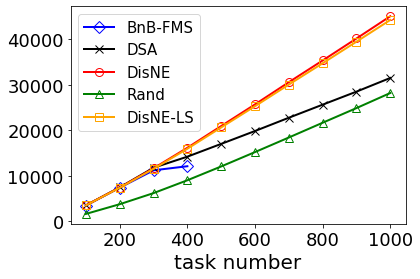

In [3]:
# plt.figure()
x = result_agg['task_num']
y1 = result_agg['BnBFMS_u']
plt.plot(x, y1, 'b-', linewidth=2, color='blue', marker='D', fillstyle='none', markersize=8)
y2 = result_agg['dsa_u']
plt.plot(x, y2, 'b-', linewidth=2, color='black', marker='x', fillstyle='none', markersize=8)
y3 = result_agg['disNE_u']
plt.plot(x, y3, 'b-', linewidth=2, color='red', marker='o', fillstyle='none', markersize=8)
y4 = result_agg['rand']
plt.plot(x, y4, 'b-', linewidth=2, color='green', marker='^', fillstyle='none', markersize=8)
y5 = result_agg['LS_u']
plt.plot(x, y5, 'b-', linewidth=2, color='orange', marker='s', fillstyle='none', markersize=8)
plt.legend(['BnB-FMS', 'DSA', 'DisNE', 'Rand', 'DisNE-LS'], fontsize=15)
# plt.ylabel('utility', fontsize=20)
plt.xlabel('task number', fontsize=20)
plt.tick_params(labelsize=18)
# plt.savefig('utility1.pdf',bbox_inches='tight')
# plt.show()
##




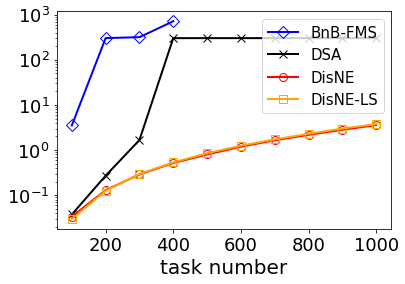

In [4]:
# plt.figure()
x = result_agg['task_num']
y1 = result_agg['BnBFMS_t']
plt.plot(x, y1, 'b-', linewidth=2, color ='blue', marker='D', fillstyle='none', markersize=8)
y2 = result_agg['dsa_t']
plt.plot(x, y2, 'b-', linewidth=2, color ='black', marker='x', fillstyle='none', markersize=8)
y3 = result_agg['disNE_t']
plt.plot(x, y3, 'b-', linewidth=2, color ='red', marker='o', fillstyle='none', markersize=8)
y4 = result_agg['LS_t']
plt.plot(x, y4, 'b-', linewidth=2,color ='orange', marker='s', fillstyle='none', markersize=8)
plt.legend(['BnB-FMS', 'DSA','DisNE', 'DisNE-LS'], fontsize=15)
ax = plt.gca()
ax.set_yscale('log')
plt.legend(['BnB-FMS', 'DSA', 'DisNE', 'DisNE-LS'], fontsize=15)
# plt.ylabel('time', fontsize=20)
plt.xlabel('task number', fontsize=20)
plt.tick_params(labelsize=18)
plt.savefig('time1.pdf',bbox_inches='tight')
# plt.show()

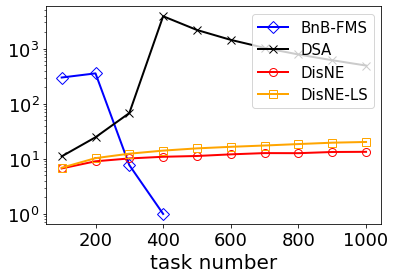

In [5]:
##
# plt.figure()
x = result_agg['task_num']
y1 = result_agg['BnBFMS_iter']
plt.plot(x, y1, 'b-', linewidth=2, color ='blue', marker='D', fillstyle='none', markersize=8)
y2 = result_agg['dsa_iter']
plt.plot(x, y2, 'b-', linewidth=2,color ='black', marker='x', fillstyle='none', markersize=8)
y3 = result_agg['disNE_iter']
plt.plot(x, y3, 'b-', linewidth=2,color ='red', marker='o', fillstyle='none', markersize=8)
y4 = result_agg['LS_iter']
plt.plot(x, y4, 'b-', linewidth=2,color ='orange', marker='s', fillstyle='none', markersize=8)
plt.legend(['BnB-FMS', 'DSA','DisNE', 'DisNE-LS'], fontsize=15)
ax = plt.gca()
ax.set_yscale('log')
# plt.ylabel('iteration', fontsize=20)
plt.xlabel('task number', fontsize=20)
plt.tick_params(labelsize=18)
plt.savefig('round1.pdf',bbox_inches='tight')
# plt.show()

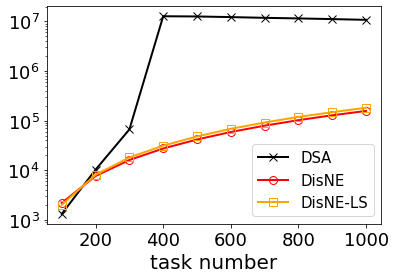

In [6]:
##
# plt.figure()
x = result_agg['task_num']
y1 = result_agg['dsa_msg']
plt.plot(x, y1, 'b-', linewidth=2, color='black', marker='x', fillstyle='none', markersize=8)
y2 = result_agg['DisNE_msg']
plt.plot(x, y2, 'b-', linewidth=2, color='red', marker='o', fillstyle='none', markersize=8)
y3 = result_agg['LS_msg_num']
plt.plot(x, y3, 'b-', linewidth=2,color ='orange', marker='s', fillstyle='none', markersize=8)
plt.legend(['DSA', 'DisNE', 'DisNE-LS'], fontsize=15)
ax = plt.gca()
ax.set_yscale('log')
# plt.ylabel('message passing', fontsize=20)
plt.xlabel('task number', fontsize=20)
plt.tick_params(labelsize=18)
plt.savefig('msg1.pdf',bbox_inches='tight')
# plt.show()


In [1]:
import time
import copy
import numpy as np
import itertools
import math
from functools import reduce # python3 compatibility
from operator import mul
import json

In [2]:
# Functions for generating environment with capability
# generating task
def gen_tasks_RF(task_num, t_agents, max_reward = 100): # task reward DB, for each task, each coaltion value is a random number between (0,100)
    tasks = [] # tasks is a list of task reward dictinoary, key represents the agent allocation in binary sum, value is a random integer
    for j in range(0, task_num):
        if j == task_num-1:
            coalitions = [(-1, 0)]
            tasks.append({key: value for (key, value) in coalitions})
        else:
            coalitions = list(itertools.chain(*[itertools.combinations(t_agents[j],i+1) for i,_ in enumerate(t_agents[j])]))
            dict_list = [(sum([2**a for a in com]), np.random.randint(1, max_reward+1)) for com in coalitions]
            tasks.append({key: value for (key, value) in dict_list})
    return tasks


def gen_tasks_RF2(task_num): # task reward DB, for each task, each coaltion value is a random number between (0,100)
    return [{} for j in range(0,task_num)]


def gen_constraints(agent_num, task_num, power=1, a_min_edge=2,
                    t_max_edge=5):  # power is the inforce you put in the probabilities

    # the maximum tasks an agent could work on depends on the number of tasks available (e.g, if |T| = 1/2|A|, the roughly each agent can work on two tasks)
    # calculate the max and min edges for agents
    seats = math.floor(t_max_edge * task_num)
    a_taskInds = [[] for i in range(0, agent_num)]
    t_counter = [0 for j in range(0, task_num)]  # each indicate the current number of agents on the task

    ## generating the number of tasks the agents could work on.
    a_taskNums = []
    for i in range(0, agent_num):
        a_max_edge = min((seats - (agent_num - 1 - i) * a_min_edge), t_max_edge)
        a_min_edge = min(a_min_edge, a_max_edge)
        a_taskNums.append(
            np.random.randint(a_min_edge, a_max_edge + 1))  # indicate the number of task the agent could work on
        seats -= a_taskNums[i]

    t_indexes = [j for j in range(0, task_num) if
                 t_counter[j] < t_max_edge]  # make sure no further draw for those reached the maximum limit.
    for i in range(0, agent_num):
        if any([tc == 0 for tc in t_counter]):
            t_prob = [(math.e ** (t_max_edge - t_counter[j])) ** power for j in
                      t_indexes]  # power is used to manify the probability
            sum_prob = sum(t_prob)
            t_prop_2 = [prop / sum_prob for prop in t_prob]

            # draw tasks accounting to their current allocations
            a_taskInds[i] = list(np.random.choice(t_indexes, min(a_taskNums[i], len(t_indexes)), replace=False,
                                                  p=[prop / sum_prob for prop in t_prob]))
            # increase the chosen task counters
        else:
            a_taskInds[i] = list(np.random.choice(t_indexes, min(a_taskNums[i], len(t_indexes)), replace=False))

        for j in a_taskInds[i]:
            t_counter[j] += 1
        t_indexes = [j for j in range(0, task_num) if
                     t_counter[j] < t_max_edge]  # make sure no further draw for those reached the maximum limit.

    # get also the list of agents for each task
    t_agents = [[i for i in range(0, agent_num) if j in a_taskInds[i]] for j in range(0, task_num)]

    return a_taskInds, t_agents


In [3]:
def task_reward_RF(task, coalition, gamma=1, max_reward=100): # task is a dict (reward DB), coalition is a list of agents (indexes)
    key = sum([2**int(coalition[i]) for i in range(0,len(coalition))])
    if key in task.keys():
        return task[key]
    else:
        task[key] = np.random.randint(0,max_reward+1)
        return task[key]
    

def sys_rewards_tasks(tasks, CS, gamma = 1): # CS is a list of coalitions
    return sum([task_reward_RF(tasks[j],CS[j],gamma) for j in range(0,len(tasks))])



def alloc_to_CS(tasks,alloc):
    task_num = len(tasks)
    CS = [[] for j in range(0, len(tasks))]
    for i in range(0,len(alloc)):
        if alloc[i]< task_num: # means allocated (!=task_num)
            CS[alloc[i]].append(i)
    return CS


def resultCal_RF(agent_num, tasks, constraints, r_msgs, iteration, iter_over, converge, gamma=1):
    a_taskInds = constraints[0]
    task_num = len(tasks)

    a_msg_sum = [{d_key: sum([r_msgs[j][i][0] for j in a_taskInds[i] if j != d_key])
                         + r_msgs[d_key][i][1] for d_key in a_taskInds[i]}
                 for i in range(0, agent_num)]

    alloc = [max(ams, key=ams.get) if ams != {} else task_num for ams in a_msg_sum]
    return alloc, sys_rewards_tasks(tasks, alloc_to_CS(tasks, alloc), gamma), iteration, iter_over, converge


# Agent contribution
def agent_con_RF(task, j, a_tasks, query_agentIndex, cur_coalition, gamma=1): # cur_coalition is a list of agents (indexes)
    if j not in a_tasks[query_agentIndex]:
        return -1000
    else:
        if query_agentIndex in cur_coalition:
            new_coalition = list(cur_coalition)
            new_coalition.remove(query_agentIndex)
            return task_reward_RF(task,cur_coalition,gamma) - task_reward_RF(task,new_coalition,gamma)
        else:
            return task_reward_RF(task,cur_coalition+[query_agentIndex],gamma) - task_reward_RF(task,cur_coalition,gamma)


def aim_tasks(movement_values, a_tasks, a_index):
    max_mv = max(movement_values['agent ' + str(a_index)])
    target_tasks = []  # aiming tasks are the tasks the agent makes proposal to
    max_num = movement_values['agent ' + str(a_index)].count(max_mv)
    first_pos = 0
    for ind in range(max_num):
        new_list = movement_values['agent ' + str(a_index)][first_pos:]
        index_add_t = first_pos + new_list.index(max_mv)
        act_task = a_tasks[a_index][index_add_t]
        target_tasks.append(act_task)
        next_pos = new_list.index(max_mv) + 1
        first_pos += next_pos
    return target_tasks


def accepted_tasks(instruction_received, propose_states, a_index):
    accept_num = instruction_received['agent ' + str(a_index)].count(1)
    accept_tasks = []  # the index of accept message, which corresponding to the index of sending tasks
    first_pos = 0
    for ind in range(accept_num):
        new_list = instruction_received['agent ' + str(a_index)][first_pos:]
        new_t_ind = first_pos + new_list.index(1)
        act_task = propose_states['agent ' + str(a_index)][new_t_ind]
        accept_tasks.append(act_task)
        next_pos = new_list.index(1) + 1
        first_pos += next_pos
    return accept_tasks



In [4]:
def OPD_RF(agent_num, tasks, constraints, gamma):
    task_num = len(tasks)
    a_taskInds = [list(con) for con in constraints[0]]
    t_agentInds = [list(con) for con in constraints[1]]

    a_ubs = [[0 for j in a_taskInds[i]] for i in range(0, agent_num)]
    a_lbs = [[0 for j in a_taskInds[i]] for i in range(0, agent_num)]

    for j in range(0, task_num):

        linked_agentInds = t_agentInds[j]
        com_dict = []
        com_rewards = []
        for c in itertools.product(*[[0, 1] for i in linked_agentInds]):
            com_dict.append({linked_agentInds[i]: c[i] for i in range(0, len(c))})
            com_rewards.append(
                task_reward_RF(tasks[j], [a_key for a_key in com_dict[-1].keys() if com_dict[-1][a_key] == 1], gamma)
            )

        for i in t_agentInds[j]:
            t_ind = a_taskInds[i].index(j)
            cons_j = [com_rewards[c]
                      for c in range(0, len(com_dict)) if com_dict[c][i] == 1]

            a_lbs[i][t_ind] = min(cons_j)
            a_ubs[i][t_ind] = max(cons_j)

    for i in range(0, agent_num):
        t_flag = [True for j in a_taskInds[i]]
        for t_ind in range(0, len(a_taskInds[i])):
            for t2_ind in range(0, len(a_taskInds[i])):
                if t_ind != t2_ind and a_ubs[i][t_ind] < a_lbs[i][t2_ind]:
                    t_flag[t_ind] = False
                    break

        for t_ind in range(0, len(t_flag)):
            if not t_flag[t_ind]:
                t_agentInds[a_taskInds[i][t_ind]].remove(i)

        new_a_taskInds = [a_taskInds[i][t_ind]
                          for t_ind in range(0, len(a_taskInds[i])) if t_flag[t_ind]]
        a_taskInds[i] = new_a_taskInds
    return a_taskInds, t_agentInds


def FMS_RF(agent_num, tasks, constraints, gamma, time_bound):
    converge = False
    iter_over = False
    start_time = time.time()
    a_taskInds = constraints[0]
    t_agentInds = constraints[1]
    task_num = len(tasks)

    q_msgs = [{t_key: {} for t_key in a_taskInds[i]} for i in range(0, agent_num)]
    r_msgs = [
        {t_agentInds[j][i]: ({1: -100} if len(a_taskInds[t_agentInds[j][i]]) == 1 else {key: -100 for key in [0, 1]})
         for i in range(0, len(t_agentInds[j]))}
        for j in range(0, task_num)]

    q_flags = [False for i in range(0, agent_num)]
    r_flags = [False for j in range(0, task_num)]

    iteration = 0
    while True:
        if time.time() - start_time >= time_bound:
            return resultCal_RF(agent_num, tasks, constraints, r_msgs, q_msgs, iteration, iter_over, converge, gamma)
        iteration += 1

        if iteration > agent_num + task_num:
            iter_over = True
            return resultCal_RF(agent_num, tasks, constraints, r_msgs, iteration, iter_over, converge, gamma)

        if all(q_flags) and all(r_flags):  # converge, msgs are all the same.
            converge = True
            break
        for i in range(0, agent_num):
            linked_taskInds = a_taskInds[i]

            flag = True
            for t_key in linked_taskInds:

                ####### check time bound
                if time.time() - start_time >= time_bound:
                    return resultCal_RF(agent_num, tasks, constraints, r_msgs, iteration, iter_over, converge,
                                     gamma)
                ####### check time bound
                msgs = {}

                if len(linked_taskInds) > 1:
                    msgs[1] = sum([m[0] for m in [r_msgs[j][i] for j in linked_taskInds if j != t_key]])
                    msg_0 = []
                    ts = list(linked_taskInds)
                    ts.remove(t_key)

                    for k in ts:
                        msg_0.append(sum([m[0] for m in [r_msgs[j][i] for j in ts if j != k]])
                                     + r_msgs[k][i][1])

                    msgs[0] = (0 if msg_0 == [] else max(msg_0))
                else:
                    msgs[1] = 0

                alphas = -sum(msgs.values()) / len(msgs.keys())

                msgs_regularised = {d_key: msgs[d_key] + alphas for d_key in msgs.keys()}

                old_msg = q_msgs[i][t_key]
                if old_msg != {} and any([abs(msgs_regularised[d_key] - old_msg[d_key]) > 10 ** (-5)
                                          for d_key in old_msg.keys()]):
                    flag = False

                q_msgs[i][t_key] = msgs_regularised

            if flag:  # agent i sending the same info
                q_flags[i] = True

        if time.time() - start_time >= time_bound:
            break
        ###################### SAME thing, using comprehension
        #             msgs = {t_key:{d_key:sum([m[d_key] for m in [r_msgs[j][i] for j in linked_taskInds if j != t_key]])
        #                            for d_key in linked_taskInds}
        #                                 for t_key in linked_taskInds}
        #             alphas = {t_key:-sum(msgs[t_key].values())/len(msgs.keys())
        #                       for t_key in linked_taskInds}
        #             msgs_regularised = {t_key:{d_key:msgs[t_key][d_key] + alphas[t_key]
        #                            for d_key in linked_taskInds}
        #                                 for t_key in linked_taskInds}
        for j in range(0, task_num):
            linked_agentInds = t_agentInds[j]
            msg_con = [q_msgs[a][j] for a in linked_agentInds]

            com_dict = []
            com_rewards = []
            dom_com = [[0, 1] if len(a_taskInds[i]) > 1 else [1] for i in linked_agentInds]

            for c in itertools.product(*dom_com):
                ####### check time bound
                if time.time() - start_time >= time_bound:
                    return resultCal_RF(agent_num, tasks, constraints, r_msgs, iteration, iter_over, converge,
                                     gamma)
                ####### check time bound

                com_dict.append({linked_agentInds[i]: c[i] for i in range(0, len(c))})
                com_rewards.append(
                    task_reward_RF(tasks[j], [a_key for a_key in com_dict[-1].keys() if com_dict[-1][a_key] == 1], gamma)
                )

            flag = True
            for a_key in linked_agentInds:

                ####### check time bound
                if time.time() - start_time >= time_bound:
                    return resultCal_RF(agent_num, tasks, constraints, r_msgs, iteration, iter_over, converge,
                                     gamma)
                ####### check time bound

                old_msg = r_msgs[j][a_key]
                q_table = []
                for c in range(0, len(com_dict)):
                    q_table.append(sum([q_msgs[a][j][com_dict[c][a]] for a in linked_agentInds if a != a_key])
                                   + com_rewards[c])

                r_msgs[j][a_key] = {
                    d_key: max([q_table[c] for c in range(0, len(com_dict)) if com_dict[c][a_key] == d_key])
                    for d_key in ([0, 1] if len(a_taskInds[a_key]) > 1 else [1])}

                if any([abs(r_msgs[j][a_key][d_key] - old_msg[d_key]) > 10 ** (-5) for d_key in old_msg.keys()]):
                    flag = False

            if flag:  # task j sending the same info
                r_flags[j] = True

    return resultCal_RF(agent_num, tasks, constraints, r_msgs, iteration, iter_over, converge, gamma)

In [5]:
def DSA_RF(constraints, tasks, agent_num, probability, time_bound):
    converge = False
    task_num = len(tasks)
    a_tasks = copy.deepcopy(constraints[0])
    [a_tasks[member].append(task_num) for member in range(0, agent_num)]
    t_agents = constraints[1]
    received_contribution = {} # zero at the task_num-th is the contribution of an agent assigned to no tasks
    for i in range(0, agent_num):
        received_contribution['agent ' + str(i)] = list(np.zeros(len(a_tasks[i]), int))
    movement_values = {}
    CS = [[] for j in range(0, task_num+1)]
    state = [task_num for i in range(0, agent_num)]
    update_t = range(0, task_num)
    iter = 0
    message_pass_num = 0
    is_continue = True
    start_time = time.time()
    while is_continue:  # > 0:
        if time.time() - start_time >= time_bound:
            break
        iter += 1

        # update agents' allocation state
        for j in range(0, task_num):
            member_agents = CS[j]
            for i in member_agents:
                state[i] = int(j)

        # tasks calculate agents contribution to them
        for j in range(0, task_num):
            if j in update_t:
                ini_con_list = []
                for i in t_agents[j]:
                    message_pass_num += 1
                    current_coal = CS[j]
                    if len(current_coal) == 0:
                        ini_contrib = task_reward_RF(tasks[j], [i], max_reward=100)
                    else:
                        coal = [mem for mem in current_coal]
                        cur_reward = task_reward_RF(tasks[j], coal, gamma=1)
                        if i in current_coal:
                            remained_mems = current_coal[:]
                            remained_mems.remove(i)
                            if len(remained_mems) == 0:
                                non_a_reward = 0
                            else:
                                remain_coal = [remai_mem for remai_mem in remained_mems]
                                non_a_reward = task_reward_RF(tasks[j], remain_coal, gamma=1)
                            ini_contrib = cur_reward - non_a_reward
                        else:
                            coal.append(i)
                            add_reward = task_reward_RF(tasks[j], coal, gamma=1)
                            ini_contrib = add_reward - cur_reward
                    j_index = a_tasks[i].index(j)
                    received_contribution['agent ' + str(i)][j_index] = ini_contrib
                    i_ind = t_agents[j].index(i)

        # agents calculate their movement values #
        for i in range(0, agent_num):
            current_task = state[i]   # the agent's current task
            if current_task == task_num:
                current_contribution = 0
            else:
                cur_t_ind = a_tasks[i].index(current_task)
                current_contribution = received_contribution['agent ' + str(i)][cur_t_ind]
            movement_values['agent ' + str(i)] = [received_contribution['agent ' + str(i)][mess_ind]-current_contribution for mess_ind in range(0, len(received_contribution['agent ' + str(i)]))]

        # agents choose their tasks  ##########
        update_t = []
        max_mv = [[] for i in range(0, agent_num)]
        for i in range(0, agent_num):
            max_mv[i] = max(movement_values['agent ' + str(i)])
            if max_mv[i] > 0:
                pro = np.random.random(1)
                if pro > 1 - probability:
                    old_task = state[i]
                    potential_task = []
                    max_num = movement_values['agent ' + str(i)].count(max_mv[i])
                    first_pos = 0
                    for ind in range(max_num):
                        new_list = movement_values['agent ' + str(i)][first_pos:]
                        poten_ind = first_pos + new_list.index(max_mv[i])
                        potential_task.append(a_tasks[i][poten_ind])
                        next_pos = new_list.index(max_mv[i]) + 1
                        first_pos += next_pos
                    choose_t_ind = np.random.randint(len(potential_task))
                    choosed_task = potential_task[choose_t_ind]
                    CS[choosed_task].append(i)
                    update_t.append(choosed_task)
                    state[i] = choosed_task
                    if old_task != task_num:
                        CS[old_task].remove(i)
                        update_t.append(old_task)
        #  if continue
        if max(max_mv) > 0:
            is_continue = True
        else:
            is_continue = False
            converge = True

    #  current system reward    #
    ini_task_u = [[] for i in range(0, task_num)]
    for j in range(0, task_num):
        if len(CS[j]) == 0:
            ini_task_u[j] = 0
        else:
            t_coalition = [c_mem for c_mem in CS[j]]
            ini_task_u[j] = task_reward_RF(tasks[j], t_coalition, gamma=1)
    global_u = sum(ini_task_u)

    return global_u, iter, message_pass_num, converge


In [6]:
def disNE_RF(constraints, tasks, agent_num, time_bound, CS=[]):
    converge = False
    task_num = len(tasks)
    a_tasks = copy.deepcopy(constraints[0])
    t_agents = copy.deepcopy(constraints[1])
    t_agents.append(list(range(0, agent_num)))
    
    if CS==[]:
        CS = [[] for j in range(0, task_num+1)]
        CS[task_num] = list(range(0, agent_num))

    received_contribution = {} # zero at the task_num-th is the contribution of an agent assigned to no tasks
    for i in range(0, agent_num):
        received_contribution['agent ' + str(i)] = list(np.zeros(len(a_tasks[i]), int))
    movement_values = {}
    
    state = [task_num for i in range(0, agent_num)]
    update_t = range(0, task_num)
    iter = 0
    message_pass_num = 0
    is_continue = True
    start_time = time.time()
    while is_continue:  # > 0:
        if time.time() - start_time >= time_bound:
            break
        iter += 1

        # update agents' allocation state
        for j in range(0, task_num):
            member_agents = CS[j]
            for i in member_agents:
                state[i] = int(j)

        # tasks calculate agents contribution to them
        for j in range(0, task_num):
            if j in update_t:
                ini_con_list = []
                for i in t_agents[j]:
                    message_pass_num += 1
                    current_coal = CS[j]
                    if len(current_coal) == 0:
                        ini_contrib = task_reward_RF(tasks[j], [i], max_reward=100)
                    else:
                        coal = [mem for mem in current_coal]
                        cur_reward = task_reward_RF(tasks[j], coal, gamma=1)
                        if i in current_coal:
                            remained_mems = current_coal[:]
                            remained_mems.remove(i)
                            if len(remained_mems) == 0:
                                non_a_reward = 0
                            else:
                                remain_coal = [remai_mem for remai_mem in remained_mems]
                                non_a_reward = task_reward_RF(tasks[j], remain_coal, gamma=1)
                            ini_contrib = cur_reward - non_a_reward
                        else:
                            coal.append(i)
                            add_reward = task_reward_RF(tasks[j], coal, gamma=1)
                            ini_contrib = add_reward - cur_reward
                    j_index = a_tasks[i].index(j)
                    received_contribution['agent ' + str(i)][j_index] = ini_contrib
                    i_ind = t_agents[j].index(i)

        # agents calculate their movement values #
        for i in range(0, agent_num):
            # print('i: ', i)
            current_task = state[i]  # the agent's current task
            if current_task == task_num:
                current_contribution = 0
            else:
                cur_t_ind = a_tasks[i].index(current_task)
                current_contribution = received_contribution['agent ' + str(i)][cur_t_ind]
            movement_values['agent ' + str(i)] = [received_contribution['agent ' + str(i)][mess_ind] - current_contribution for mess_ind in
                range(0, len(received_contribution['agent ' + str(i)]))]


        max_mv = [max(movement_values['agent ' + str(i)]) for i in range(0, agent_num)]
        # check whether or not to continue  #
        if max(max_mv) <= 0:  # in this case, no agent will propose
            is_continue = False
            converge = True
        if is_continue:
            # agents propose to tasks #
            received_proposal = [{'from agents': [], 'proposal values': []} for j in range(0, task_num)]  # received proposals
            propose_states = {}  # which agents propose to which tasks
            propose_agents = []  # which agents make proposals
            received_tasks = []  # which tasks receive proposals
            for i in range(0, agent_num):
                if max_mv[i] > 0:
                    propose_agents.append(i)
                    pick_tasks = [k for k, x in enumerate(movement_values['agent ' + str(i)]) if x == max_mv[i]]
                    aim_tasks = [a_tasks[i][k] for k in pick_tasks]
                    old_task = state[i]
                    if old_task != task_num:
                        aim_tasks.append(old_task)
                    propose_states['agent ' + str(i)] = aim_tasks
                    received_tasks.append(aim_tasks)
                    for j in aim_tasks:
                        received_proposal[j]['from agents'].append(i)
                        received_proposal[j]['proposal values'].append(max_mv[i])
                    message_pass_num += len(aim_tasks)


            #  find out which coalitions received proposal
            active_tasks = []
            for j in received_tasks:
                active_tasks.extend(j)
            active_tasks = list(set(active_tasks))
            # tasks send instruction messages to agents #
            instruction_received = {}  # instruction received by the proposed agents
            for i in propose_agents:
                instruction_received['agent ' + str(i)] = [0] * len(propose_states['agent ' + str(i)])  # 0: reject, 1: accept

            for j in active_tasks:
                message_pass_num += len(received_proposal[j]['from agents'])
                max_pro = max(received_proposal[j]['proposal values'])
                candi_agents = [k for k, x in enumerate(received_proposal[j]['proposal values']) if x == max_pro]
                poent_accep_agents = [received_proposal[j]['from agents'][k] for k in
                                      candi_agents]  # the agents who give the maximum proposal
                choosed_agent = np.random.choice(poent_accep_agents)  # the agent index accepted by task j
                acc_t_ind = propose_states['agent ' + str(int(choosed_agent))].index(j)  # the index of task j
                instruction_received['agent ' + str(int(choosed_agent))][acc_t_ind] = 1

            # agents move to tasks
            update_t = []
            for i in propose_agents:
                accept_num = instruction_received['agent ' + str(i)].count(1)
                if accept_num == 0:
                    continue
                else:
                    accept_ind = [k for k, x in enumerate(instruction_received['agent ' + str(i)]) if x == 1]
                    accept_tasks = [propose_states['agent ' + str(i)][k] for k in accept_ind]
                    ########### moving condition ############
                    # i) the agent has not been allocated and it receives 1 (accept) from its target-task(s).
                    # ii) the agent has a current task and it receives 1 from both its target-task(s) and its current task.
                    old_coa = state[i]
                    if old_coa != task_num:
                        old_coa_ind = propose_states['agent ' + str(i)].index(old_coa)
                        if instruction_received['agent ' + str(i)][
                            old_coa_ind] == 0:  # the agent's own task reject its movement
                            continue
                        else:
                            accept_tasks.remove(old_coa)  # the other accept-coalitions besides its own coalition
                    if len(accept_tasks) == 0:
                        continue
                    else:
                        choosed_task = np.random.choice(accept_tasks)  # random select a coalition that gives accept message
                        CS[choosed_task].append(i)
                        CS[old_coa].remove(i)
                        message_pass_num += 1
                        update_t.append(choosed_task)
                        if old_coa != task_num:
                            message_pass_num += 1
                            update_t.append(old_coa)

    # current system reward #
    ini_task_u = [[] for j in range(0, task_num)]
    for j in range(0, task_num):
        if len(CS[j]) == 0:
            ini_task_u[j] = 0
        else:
            t_coalition = [c_mem for c_mem in CS[j]]
            ini_task_u[j] = task_reward_RF(tasks[j], t_coalition, gamma=1)
    global_u = sum(ini_task_u)

    return global_u, iter, message_pass_num, converge


In [7]:
def random(agent_num,tasks,constraints, gamma = 1):
    task_num = len(tasks)
    a_taskInds = copy.deepcopy(constraints[0])
    alloc = [np.random.choice(a_taskInds[i]+[task_num]) for i in range(0,agent_num)]
    return alloc, sys_rewards_tasks(tasks, alloc_to_CS(tasks,alloc), gamma)

In [8]:
def append_record(record, filename, typ):
    with open(filename, 'a') as f:
        if typ != '':
            json.dump(record, f, default = typ)
        else:
            json.dump(record, f)
        f.write('\n')
        # f.write(os.linesep)
        f.close()

In [ ]:
run_num = 100
probability = 0.7
time_bound = 300
max_t_num = 1000
capNum = 10
max_capNum_task = 10
max_capNum_agent = 10

a_min_edge = 1
min_t_num = 100
ex_identifier = 0


# compare algorithms
for run in range(0, run_num):
    print('run:', run)
    task_num = min_t_num
    while task_num <= max_t_num:
        ex_identifier += 1
        t_max_edge = 0.04 * task_num
        agent_num = 2 * task_num
        constraints = gen_constraints(agent_num, task_num, 1, a_min_edge, t_max_edge) #max(M,N)
        t_agents = copy.deepcopy(constraints[1])
        t_agents.append(list(range(0, agent_num)))

        if t_max_edge <= 17:
            tasks = gen_tasks_RF(task_num, t_agents)
        else: 
            tasks = gen_tasks_RF2(task_num)


        result = {"ex_identifier": ex_identifier, "task_num": task_num, "agent_num": agent_num}

        
        ##  BnB-FMS
        if t_max_edge <= 17:
            start = time.time()
            new_con = OPD_RF(agent_num, tasks, constraints, gamma=1)
            r = FMS_RF(agent_num, tasks, new_con, gamma=1, time_bound=time_bound)
            end = time.time()
            result['BnBFMS_u'] = r[1]
            result['BnBFMS_t'] = end - start
            result['BnBFMS_iter'] = r[2]
            result['BnBFMS_converge'] = r[4]
            print("task_number: ", task_num, "BnBFMS time:", result['BnBFMS_t'],'result:',result['BnBFMS_u'],
                  "iteration:", result['BnBFMS_iter'], "converge?", result['BnBFMS_converge'])

        #  Rand
        r = random(agent_num, tasks,constraints, gamma=1)
        alloc = r[0]
        result['rand'] = r[1]
        print("task_number: ", task_num, 'rand result',result['rand'])
        rand_CS = [[] for i in list(range(0, task_num + 1))]
        for i in list(range(0, agent_num)):
            rand_CS[alloc[i]].append(i)


        ##  DSA
        start = time.time()
        dsa_u, dsa_iter, dsa_msg_num, if_converge = DSA_RF(constraints, tasks, agent_num, probability, time_bound)
        end = time.time()
        result['dsa_u'] = dsa_u
        result['dsa_t'] = end-start
        result['dsa_iter'] = dsa_iter
        result['dsa_msg'] = dsa_msg_num
        result['DSA_converge'] = if_converge
        print("task_number: ", task_num, "DSA time:", result['dsa_t'],'result:', result['dsa_u'],
              "iteration:", result['dsa_iter'], "messages", result['dsa_msg'], "converge?", result['DSA_converge'])
        print()
        
        
        ##  DisNE starts from a random solution
        rand_disne = copy.deepcopy(rand_CS) 
        start = time.time()
        LS_u, LS_iter, LS_msg_num, if_converge = disNE_RF(constraints, tasks, agent_num, time_bound, rand_disne)
        end = time.time()
        result['LS_u'] = LS_u
        result['LS_t'] = end - start
        result['LS_iter'] = LS_iter
        result['LS_msg_num'] = LS_msg_num
        result['LS_converge'] = if_converge
        print("task number: ", task_num, "LS_t:", result['LS_t'], 'LS_u:', LS_u,
                "LS_iter:", LS_iter, "messages", result['LS_msg_num'], "converge?", result['LS_converge'])
        print()
        
        ##  DisNE
        start = time.time()
        disNE_u, disNE_iter, disNE_msg_num, if_converge = disNE_RF(constraints, tasks, agent_num, time_bound, [])
        end = time.time()
        result['disNE_u'] = disNE_u
        result['disNE_t'] = end-start
        result['disNE_iter'] = disNE_iter
        result['DisNE_msg'] = disNE_msg_num
        result['DisNE_converge'] = if_converge
        print("task_number: ", task_num, "disNE time:", result['disNE_t'],'result:',result['disNE_u'],
              "iteration:", result['disNE_iter'], "messages", result['DisNE_msg'], "converge?", result['DisNE_converge'])
        print()

# #         # append data and result
#         files = {'gen_RF_thesis': [result, '']}
#         for filename in list(files.keys()):
#             append_record(files[filename][0], filename, typ=files[filename][1])

#         increase the task_number
        task_num += 100
    run += 1




run: 0
task_number:  100 BnBFMS time: 3.7016208171844482 result: 7278 iteration: 301 converge? False
task_number:  100 rand result 4715
task_number:  100 DSA time: 0.029215097427368164 result: 8079 iteration: 15 messages 1612 converge? True

task number:  100 LS_t: 0.01409769058227539 LS_u: 7878 LS_iter: 7 messages 1541 converge? True

task_number:  100 disNE time: 0.01145029067993164 result: 8009 iteration: 5 messages 1504 converge? True



In [1]:
import json
import os
import pandas as pd

def load_json(filename):
    with open(filename) as f:
        dict_list = [json.loads(line) for line in f]
    return dict_list



In [2]:
import pandas as pd
# from load_json import load_json
import matplotlib.pyplot as plt

result_list = load_json('gen_RF_thesis')
df_result = pd.DataFrame(result_list, columns=list(result_list[0].keys()))
df_result.head()
agg_dict = {key: 'mean' for key in result_list[0].keys()}
del agg_dict['ex_identifier']
del agg_dict['task_num']
del agg_dict['agent_num']
del agg_dict['DSA_converge']
del agg_dict['BnBFMS_converge']


result_agg = df_result.groupby(['task_num'], as_index=False).agg(agg_dict)
show_grouped_result = pd.DataFrame(result_agg)
show_grouped_result

,task_num,BnBFMS_u,BnBFMS_t,BnBFMS_iter,rand,dsa_u,dsa_t,dsa_iter,dsa_msg,LS_u,LS_t,LS_iter,LS_msg_num,LS_converge,disNE_u,disNE_t,disNE_iter,DisNE_msg,DisNE_converge
0,100,7856.87,1.753296,98.98,5019.73,7922.01,0.038201,15.00,1571.16,7640.91,0.017725,5.82,1389.96,True,8133.50,0.016850,5.05,1580.72,True
1,200,16300.60,300.456583,196.46,10102.29,17502.08,0.225980,29.74,10198.88,16814.29,0.071439,8.30,5733.74,True,17881.22,0.058377,6.31,5195.92,True
2,300,15324.75,310.052512,4.00,15228.33,27348.33,1.162731,74.39,48639.00,26080.69,0.176702,10.11,12668.96,True,27890.73,0.128478,6.72,10779.45,True
3,400,20281.15,805.806582,1.00,20245.08,37509.28,16.534995,515.91,557125.44,35397.32,0.375290,10.95,21901.45,True,37944.63,0.237787,6.84,18329.35,True
4,500,NaN,NaN,NaN,25012.43,44048.05,300.074540,4947.24,10393426.14,44614.78,0.544445,11.83,33320.57,True,47959.21,0.375606,7.09,27753.79,True
5,600,NaN,NaN,NaN,30055.53,51823.60,300.106633,2751.47,9999071.31,54040.03,0.814472,12.49,47331.14,True,57993.14,0.545925,7.30,39120.93,True
6,700,NaN,NaN,NaN,35073.35,60098.30,300.150556,1804.01,9466719.89,63423.86,1.187146,13.25,63731.41,True,68035.41,0.776655,7.24,52331.11,True
7,800,NaN,NaN,NaN,40001.24,68237.56,300.217142,1262.11,8860216.14,72772.10,1.623184,13.28,81522.52,True,78079.61,1.058291,7.54,67375.14,True
8,900,NaN,NaN,NaN,45023.85,76532.34,300.292678,924.21,8363995.07,82235.19,2.131933,13.79,102208.72,True,88129.78,1.377194,7.63,84369.87,True
9,1000,NaN,NaN,NaN,49854.74,84917.01,300.334548,705.77,7929024.19,91646.57,2.745681,14.09,125105.42,True,98162.49,1.747135,7.52,102928.25,True


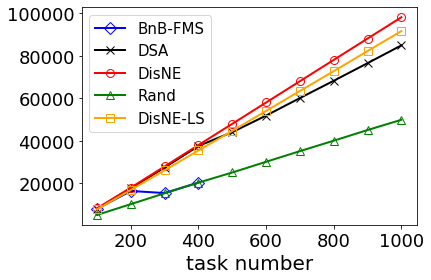

In [3]:
# plt.figure()
x = result_agg['task_num']
y1 = result_agg['BnBFMS_u']
plt.plot(x, y1, 'b-', linewidth=2, color='blue', marker='D', fillstyle='none', markersize=8)
y2 = result_agg['dsa_u']
plt.plot(x, y2, 'b-', linewidth=2, color='black', marker='x', fillstyle='none', markersize=8)
y3 = result_agg['disNE_u']
plt.plot(x, y3, 'b-', linewidth=2, color='red', marker='o', fillstyle='none', markersize=8)
y4 = result_agg['rand']
plt.plot(x, y4, 'b-', linewidth=2, color='green', marker='^', fillstyle='none', markersize=8)
y5 = result_agg['LS_u']
plt.plot(x, y5, 'b-', linewidth=2, color='orange', marker='s', fillstyle='none', markersize=8)
plt.legend(['BnB-FMS', 'DSA', 'DisNE', 'Rand', 'DisNE-LS'], fontsize=15)
# plt.ylabel('utility', fontsize=20)
plt.xlabel('task number', fontsize=20)
plt.tick_params(labelsize=18)
plt.savefig('utilityRF.pdf',bbox_inches='tight')
# plt.show()
##




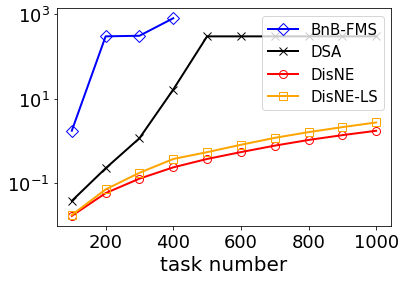

In [4]:
# plt.figure()
x = result_agg['task_num']
y1 = result_agg['BnBFMS_t']
plt.plot(x, y1, 'b-', linewidth=2, color ='blue', marker='D', fillstyle='none', markersize=8)
y2 = result_agg['dsa_t']
plt.plot(x, y2, 'b-', linewidth=2, color ='black', marker='x', fillstyle='none', markersize=8)
y3 = result_agg['disNE_t']
plt.plot(x, y3, 'b-', linewidth=2, color ='red', marker='o', fillstyle='none', markersize=8)
y4 = result_agg['LS_t']
plt.plot(x, y4, 'b-', linewidth=2,color ='orange', marker='s', fillstyle='none', markersize=8)
ax = plt.gca()
ax.set_yscale('log')
plt.legend(['BnB-FMS', 'DSA','DisNE', 'DisNE-LS'], fontsize=15)
# plt.ylabel('time', fontsize=20)
plt.xlabel('task number', fontsize=20)
plt.tick_params(labelsize=18)
plt.savefig('timeRF.pdf',bbox_inches='tight')
# plt.show()

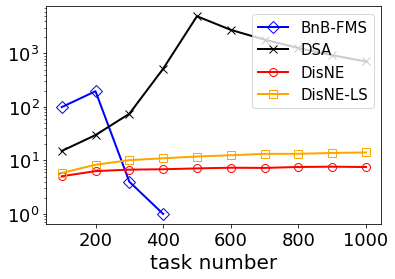

In [5]:
##
# plt.figure()
x = result_agg['task_num']
y1 = result_agg['BnBFMS_iter']
plt.plot(x, y1, 'b-', linewidth=2, color ='blue', marker='D', fillstyle='none', markersize=8)
y2 = result_agg['dsa_iter']
plt.plot(x, y2, 'b-', linewidth=2,color ='black', marker='x', fillstyle='none', markersize=8)
y3 = result_agg['disNE_iter']
plt.plot(x, y3, 'b-', linewidth=2,color ='red', marker='o', fillstyle='none', markersize=8)
y4 = result_agg['LS_iter']
plt.plot(x, y4, 'b-', linewidth=2,color ='orange', marker='s', fillstyle='none', markersize=8)
plt.legend(['BnB-FMS', 'DSA','DisNE', 'DisNE-LS'], fontsize=15)
ax = plt.gca()
ax.set_yscale('log')
# plt.ylabel('iteration', fontsize=20)
plt.xlabel('task number', fontsize=20)
plt.tick_params(labelsize=18)
plt.savefig('roundRF.pdf',bbox_inches='tight')
# plt.show()

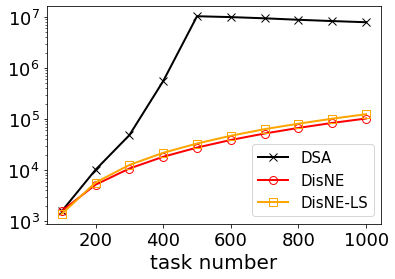

In [6]:
##
# plt.figure()
x = result_agg['task_num']
y1 = result_agg['dsa_msg']
plt.plot(x, y1, 'b-', linewidth=2, color='black', marker='x', fillstyle='none', markersize=8)
y2 = result_agg['DisNE_msg']
plt.plot(x, y2, 'b-', linewidth=2, color='red', marker='o', fillstyle='none', markersize=8)
y3 = result_agg['LS_msg_num']
plt.plot(x, y3, 'b-', linewidth=2,color ='orange', marker='s', fillstyle='none', markersize=8)
plt.legend(['DSA', 'DisNE', 'DisNE-LS'], fontsize=15)
ax = plt.gca()
ax.set_yscale('log')
# plt.ylabel('message passing', fontsize=20)
plt.xlabel('task number', fontsize=20)
plt.tick_params(labelsize=18)
plt.savefig('msgRF.pdf',bbox_inches='tight')
# plt.show()


In [1]:
import time
import numpy as np
import itertools
import math
from functools import reduce # python3 compatibility
from operator import mul
import json

In [2]:
# Functions for generating environment with capability
# generating task
def gen_tasks(task_num, max_capNum, capabilities): # n is the number of task, max_capNum is the maximum number of cap a task could require
    return [sorted(np.random.choice(capabilities, np.random.randint(1, max_capNum+1),replace=False)) for j in range(0, task_num)]


def gen_constraints(agent_num, task_num, power=1, a_min_edge=2,
                    t_max_edge=5):  # power is the inforce you put in the probabilities

    # the maximum tasks an agent could work on depends on the number of tasks available (e.g, if |T| = 1/2|A|, the roughly each agent can work on two tasks)
    # calculate the max and min edges for agents
    seats = math.floor(t_max_edge * task_num)
    a_taskInds = [[] for i in range(0, agent_num)]
    t_counter = [0 for j in range(0, task_num)]  # each indicate the current number of agents on the task

    ## generating the number of tasks the agents could work on.
    a_taskNums = []
    for i in range(0, agent_num):
        a_max_edge = min((seats - (agent_num - 1 - i) * a_min_edge), t_max_edge)
        a_min_edge = min(a_min_edge, a_max_edge)
        a_taskNums.append(
            np.random.randint(a_min_edge, a_max_edge + 1))  # indicate the number of task the agent could work on
        seats -= a_taskNums[i]

    t_indexes = [j for j in range(0, task_num) if
                 t_counter[j] < t_max_edge]  # make sure no further draw for those reached the maximum limit.
    for i in range(0, agent_num):
        if any([tc == 0 for tc in t_counter]):
            t_prob = [(math.e ** (t_max_edge - t_counter[j])) ** power for j in
                      t_indexes]  # power is used to manify the probability
            sum_prob = sum(t_prob)
            t_prop_2 = [prop / sum_prob for prop in t_prob]

            # draw tasks accounting to their current allocations
            a_taskInds[i] = list(np.random.choice(t_indexes, min(a_taskNums[i], len(t_indexes)), replace=False,
                                                  p=[prop / sum_prob for prop in t_prob]))
            # increase the chosen task counters
        else:
            a_taskInds[i] = list(np.random.choice(t_indexes, min(a_taskNums[i], len(t_indexes)), replace=False))

        for j in a_taskInds[i]:
            t_counter[j] += 1
        t_indexes = [j for j in range(0, task_num) if
                     t_counter[j] < t_max_edge]  # make sure no further draw for those reached the maximum limit.

    # get also the list of agents for each task
    t_agents = [[i for i in range(0, agent_num) if j in a_taskInds[i]] for j in range(0, task_num)]

    return a_taskInds, t_agents


def gen_agents(constraints, tasks, max_capNum, capabilities,
               max_capVal):  # m is the number of task, max_capNum is the maximum number of cap a task could require, max_capVal is the maximum capability value

    a_taskInds = constraints[0]
    agent_num = len(a_taskInds)
    caps_lists = []
    contri_lists = []
    for i in range(0, agent_num):
        t_caps = [tasks[j] for j in a_taskInds[i]]  # lists of caps that each task agent could perform

        caps_union = set(itertools.chain(*t_caps))  # union of caps of tasks that agent could perform
        a_cap_num = np.random.randint(min(3, max_capNum, len(caps_union)),
                                      min(len(caps_union), max_capNum) + 1)  # the num of caps the agent will have

        a_caps = set([np.random.choice(t_c) for t_c in
                      t_caps])  # initial draw to guarantee the agent has some contribution to each of the task that he could do

        rest_choices = list(caps_union.difference(a_caps))
        if rest_choices != []:
            # if min(len(rest_choices), a_cap_num - len(a_taskInds[i])) < 0:
            #     print("negative number a_cap_num - len(a_taskInds[i]): {}!".format(a_cap_num - len(a_taskInds[i])))
            # else:
            update_len = max(0, a_cap_num - len(a_taskInds[i]))
            a_caps.update(np.random.choice(rest_choices, min(len(rest_choices), update_len), replace=False))

        caps_lists.append(sorted(list(a_caps)))

        contri_lists.append(
            [(np.random.randint(1, max_capVal + 1) if c in caps_lists[i] else 0) for c in range(0, len(capabilities))])
    return caps_lists, contri_lists



In [3]:
def random(agents, tasks, constraints, gamma = 1):
    task_num = len(tasks)
    agent_num = len(agents)
    a_taskInds = constraints[0]
    alloc = [np.random.choice(a_taskInds[i]+[task_num]) for i in range(0,agent_num)]
    return alloc, sys_reward_agents(agents,tasks, alloc, gamma)

In [4]:
def task_reward(task, agents, gamma=1):  # task is represented by a list of capabilities it requires, agents is
    # a list of agents, where each represented by a list cap contribution values
    if agents == []:
        return 0
    else:
        return sum([max([agent[cap] for agent in agents]) for cap in task]) * (gamma ** len(agents))


def sys_reward_agents(agents, tasks, alloc, gamma=1): #alloc is a vector of size M each element indicate which task the agent is alloated to
    return sum([task_reward(tasks[j], [agents[i] for i in range(0,len(agents)) if alloc[i] == j], gamma) for j in range(0, len(tasks))])


def resultCal(agents, tasks, constraints, r_msgs, iteration, iter_over, converge, gamma=1):
    a_taskInds = constraints[0]
    agent_num = len(agents)
    task_num = len(tasks)
    a_msg_sum = [{d_key: sum([r_msgs[j][i][0] for j in a_taskInds[i] if j != d_key])
                         + r_msgs[d_key][i][1] for d_key in a_taskInds[i]}
                 for i in range(0, agent_num)]
    alloc = [max(ams, key=ams.get) if ams != {} else task_num for ams in a_msg_sum]
    return alloc, sys_reward_agents(agents, tasks, alloc, gamma), iteration, iter_over, converge


# Agent contribution
def agent_con(competency_lists, t_caps_lists, query_agentIndex, query_taskIndex, member, a_taskInds):
    # the marginal contribution of an agent to a coalition
    if query_taskIndex == len(t_caps_lists):
        return 0
    if query_taskIndex not in a_taskInds[query_agentIndex]:
        return 0
    curr_pro = [competency_lists[mem] for mem in member]
    cur_reward = task_reward(t_caps_lists[query_taskIndex], curr_pro, gamma=1)
    if query_agentIndex in member:
        remained_mems = member[:]
        remained_mems.remove(query_agentIndex)  # the remained coalition members besides of agent i
        coal_pro = [competency_lists[mem] for mem in remained_mems]
        new_reward = task_reward(t_caps_lists[query_taskIndex], coal_pro, gamma=1)
        return cur_reward - new_reward
    else:
        added_mems = member[:]
        added_mems.append(query_agentIndex)
        coal_pro = [competency_lists[mem] for mem in added_mems]
        new_reward = task_reward(t_caps_lists[query_taskIndex], coal_pro, gamma=1)
        return new_reward - cur_reward


def aim_tasks(movement_values, a_tasks, a_index):
    max_mv = max(movement_values['agent ' + str(a_index)])
    target_tasks = []  # aiming tasks are the tasks the agent makes proposal to
    max_num = movement_values['agent ' + str(a_index)].count(max_mv)
    first_pos = 0
    for ind in range(max_num):
        new_list = movement_values['agent ' + str(a_index)][first_pos:]
        index_add_t = first_pos + new_list.index(max_mv)
        act_task = a_tasks[a_index][index_add_t]
        target_tasks.append(act_task)
        next_pos = new_list.index(max_mv) + 1
        first_pos += next_pos
    return target_tasks


def accepted_tasks(instruction_received, propose_states, a_index):
    accept_num = instruction_received['agent ' + str(a_index)].count(1)
    accept_tasks = []  # the index of accept message, which corresponding to the index of sending tasks
    first_pos = 0
    for ind in range(accept_num):
        new_list = instruction_received['agent ' + str(a_index)][first_pos:]
        new_t_ind = first_pos + new_list.index(1)
        act_task = propose_states['agent ' + str(a_index)][new_t_ind]
        accept_tasks.append(act_task)
        next_pos = new_list.index(1) + 1
        first_pos += next_pos
    return accept_tasks



In [5]:
def OPD(agents, tasks, constraints, gamma):
    task_num = len(tasks)
    agent_num = len(agents)
    a_taskInds = [list(con) for con in constraints[0]]
    t_agentInds = [list(con) for con in constraints[1]]

    a_ubs = [[0 for j in a_taskInds[i]] for i in range(0, agent_num)]
    a_lbs = [[0 for j in a_taskInds[i]] for i in range(0, agent_num)]

    for j in range(0, task_num):

        linked_agentInds = t_agentInds[j]
        com_dict = []
        com_rewards = []
        for c in itertools.product(*[[0, 1] for i in linked_agentInds]):
            com_dict.append({linked_agentInds[i]: c[i] for i in range(0, len(c))})
            com_rewards.append(
                task_reward(tasks[j], [agents[a_key] for a_key in com_dict[-1].keys() if com_dict[-1][a_key] == 1],
                            gamma)
            )

        for i in t_agentInds[j]:
            t_ind = a_taskInds[i].index(j)
            cons_j = [com_rewards[c]
                      for c in range(0, len(com_dict)) if com_dict[c][i] == 1]

            a_lbs[i][t_ind] = min(cons_j)
            a_ubs[i][t_ind] = max(cons_j)

    for i in range(0, agent_num):
        t_flag = [True for j in a_taskInds[i]]
        for t_ind in range(0, len(a_taskInds[i])):
            for t2_ind in range(0, len(a_taskInds[i])):
                if t_ind != t2_ind and a_ubs[i][t_ind] < a_lbs[i][t2_ind]:
                    t_flag[t_ind] = False
                    break

        for t_ind in range(0, len(t_flag)):
            if not t_flag[t_ind]:
                t_agentInds[a_taskInds[i][t_ind]].remove(i)

        new_a_taskInds = [a_taskInds[i][t_ind]
                          for t_ind in range(0, len(a_taskInds[i])) if t_flag[t_ind]]
        a_taskInds[i] = new_a_taskInds

    return a_taskInds, t_agentInds


def FMS(agents, tasks, constraints, gamma, time_bound):
    converge = False
    iter_over = False
    record_u = []
    record_t = []
    start_time = time.time()
    a_taskInds = constraints[0]
    t_agentInds = constraints[1]
    task_num = len(tasks)
    agent_num = len(agents)

    q_msgs = [{t_key: {} for t_key in a_taskInds[i]} for i in range(0, agent_num)]
    r_msgs = [
        {t_agentInds[j][i]: ({1: -100} if len(a_taskInds[t_agentInds[j][i]]) == 1 else {key: -100 for key in [0, 1]})
         for i in range(0, len(t_agentInds[j]))}
        for j in range(0, task_num)]

    q_flags = [False for i in range(0, agent_num)]
    r_flags = [False for j in range(0, task_num)]

    iteration = 0
    while iteration < agent_num + task_num:  # True:
        if time.time() - start_time >= time_bound:
            r = resultCal(agents, tasks, constraints, r_msgs, iteration, iter_over, converge, gamma)
        iteration += 1

        if iteration > agent_num + task_num:
            iter_over = True
            r = resultCal(agents, tasks, constraints, r_msgs, iteration, iter_over, converge, gamma)

        if all(q_flags) and all(r_flags):  # converge, msgs are all the same.
            converge = True
            # break
        for i in range(0, agent_num):
            linked_taskInds = a_taskInds[i]

            flag = True
            for t_key in linked_taskInds:

                ####### check time bound
                if time.time() - start_time >= time_bound:
                    r = resultCal(agents, tasks, constraints, r_msgs, iteration, iter_over, converge, gamma)
                ####### check time bound
                msgs = {}

                if len(linked_taskInds) > 1:
                    msgs[1] = sum([m[0] for m in [r_msgs[j][i] for j in linked_taskInds if j != t_key]])
                    msg_0 = []
                    ts = list(linked_taskInds)
                    ts.remove(t_key)

                    for k in ts:
                        msg_0.append(sum([m[0] for m in [r_msgs[j][i] for j in ts if j != k]])
                                     + r_msgs[k][i][1])

                    msgs[0] = (0 if msg_0 == [] else max(msg_0))
                else:
                    msgs[1] = 0

                alphas = -sum(msgs.values()) / len(msgs.keys())

                msgs_regularised = {d_key: msgs[d_key] + alphas for d_key in msgs.keys()}

                old_msg = q_msgs[i][t_key]
                if old_msg != {} and any([abs(msgs_regularised[d_key] - old_msg[d_key]) > 10 ** (-5)
                                          for d_key in old_msg.keys()]):
                    flag = False

                q_msgs[i][t_key] = msgs_regularised

            if flag:  # agent i sending the same info
                q_flags[i] = True

        if time.time() - start_time >= time_bound:
            break
        ###################### SAME thing, using comprehension
        #             msgs = {t_key:{d_key:sum([m[d_key] for m in [r_msgs[j][i] for j in linked_taskInds if j != t_key]])
        #                            for d_key in linked_taskInds}
        #                                 for t_key in linked_taskInds}
        #             alphas = {t_key:-sum(msgs[t_key].values())/len(msgs.keys())
        #                       for t_key in linked_taskInds}
        #             msgs_regularised = {t_key:{d_key:msgs[t_key][d_key] + alphas[t_key]
        #                            for d_key in linked_taskInds}
        #                                 for t_key in linked_taskInds}
        for j in range(0, task_num):
            linked_agentInds = t_agentInds[j]
            # msg_con = [q_msgs[a][j] for a in linked_agentInds]

            com_dict = []
            com_rewards = []
            dom_com = [[0, 1] if len(a_taskInds[i]) > 1 else [1] for i in linked_agentInds]

            for c in itertools.product(*dom_com):
                ####### check time bound
                if time.time() - start_time >= time_bound:
                    r = resultCal(agents, tasks, constraints, r_msgs, iteration, iter_over, converge, gamma)
                ####### check time bound

                com_dict.append({linked_agentInds[i]: c[i] for i in range(0, len(c))})
                com_rewards.append(
                    task_reward(tasks[j], [agents[a_key] for a_key in com_dict[-1].keys() if com_dict[-1][a_key] == 1],
                                gamma)
                )

            flag = True
            for a_key in linked_agentInds:

                ####### check time bound
                if time.time() - start_time >= time_bound:
                    r = resultCal(agents, tasks, constraints, r_msgs, iteration, iter_over, converge, gamma)
                ####### check time bound

                old_msg = r_msgs[j][a_key]
                q_table = []
                for c in range(0, len(com_dict)):
                    q_table.append(sum([q_msgs[a][j][com_dict[c][a]] for a in linked_agentInds if a != a_key])
                                   + com_rewards[c])

                r_msgs[j][a_key] = {
                    d_key: max([q_table[c] for c in range(0, len(com_dict)) if com_dict[c][a_key] == d_key])
                    for d_key in ([0, 1] if len(a_taskInds[a_key]) > 1 else [1])}

                if any([abs(r_msgs[j][a_key][d_key] - old_msg[d_key]) > 10 ** (-5) for d_key in old_msg.keys()]):
                    flag = False

            if flag:  # task j sending the same info
                r_flags[j] = True

        record_t.append(time.time() - start_time)
        r = resultCal(agents, tasks, constraints, r_msgs, iteration, iter_over, converge, gamma)        
        record_u.append(r[1])

    return record_u, record_t   


In [6]:
def embed_DSA(constraints, tasks, agents, probability, time_bound):
    converge = False
    record_u = []
    record_t = []
    record_message = []
    agent_num = len(agents)
    task_num = len(tasks)
    a_tasks = constraints[0]
    t_agents = constraints[1]
    contributions = {}
    for j in range(0, task_num):
        contributions['towards task ' + str(j)] = list(np.zeros(len(t_agents[j]), int))
    received_contribution = {} # zero at the task_num-th is the contribution of an agent assigned to no tasks
    for i in range(0, agent_num):
        received_contribution['agent ' + str(i)] = list(np.zeros(len(a_tasks[i])+1, int))
    movement_values = {}
    CS = [[] for j in range(0, task_num+1)]
    state = [task_num for i in range(0, agent_num)]
    update_t = range(0, task_num)
    iter = 0
    
    is_continue = True
    start_time = time.time()
    while is_continue:  # > 0:
        message_pass_num = 0
        if time.time() - start_time >= time_bound:
            break
        iter += 1

        # update agents' allocation state
        for j in range(0, task_num):
            member_agents = CS[j]
            for i in member_agents:
                state[i] = int(j)

        # tasks calculate agents contribution to them
        for j in range(0, task_num):
            if j in update_t:
                for i in t_agents[j]:
                    message_pass_num += 1
                    current_coal = CS[j]
                    if len(current_coal) == 0:
                        coal = [agents[i]]
                        add_reward = task_reward(tasks[j], coal, gamma=1)
                        ini_contrib = add_reward
                    else:
                        coal = [agents[mem] for mem in current_coal]
                        cur_reward = task_reward(tasks[j], coal, gamma=1)
                        if i in current_coal:
                            remained_mems = current_coal[:]
                            remained_mems.remove(i)
                            if len(remained_mems) == 0:
                                non_a_reward = 0
                            else:
                                remain_coal = [agents[remai_mem] for remai_mem in remained_mems]
                                non_a_reward = task_reward(tasks[j], remain_coal, gamma=1)
                            ini_contrib = cur_reward - non_a_reward
                        else:
                            coal.append(agents[i])
                            add_reward = task_reward(tasks[j], coal, gamma=1)
                            ini_contrib = add_reward - cur_reward
                    j_index = a_tasks[i].index(j)
                    received_contribution['agent ' + str(i)][j_index] = ini_contrib
                    i_ind = t_agents[j].index(i)
                    contributions['towards task ' + str(j)][i_ind] = ini_contrib

        # agents calculate their movement values #
        for i in range(0, agent_num):
            current_task = state[i]   # the agent's current task
            if current_task == task_num:
                current_contribution = 0
            else:
                cur_t_ind = a_tasks[i].index(current_task)
                current_contribution = received_contribution['agent ' + str(i)][cur_t_ind]
            movement_values['agent ' + str(i)] = [received_contribution['agent ' + str(i)][mess_ind]-current_contribution for mess_ind in range(0, len(received_contribution['agent ' + str(i)]))]

        # agents choose their tasks  ##########
        update_t = []
        max_mv = [[] for i in range(0, agent_num)]
        for i in range(0, agent_num):
            max_mv[i] = max(movement_values['agent ' + str(i)])
            if max_mv[i] > 0:
                pro = np.random.random(1)
                if pro > 1 - probability:
                    old_task = state[i]
                    potential_task = []
                    max_num = movement_values['agent ' + str(i)].count(max_mv[i])
                    first_pos = 0
                    for ind in range(max_num):
                        new_list = movement_values['agent ' + str(i)][first_pos:]
                        potential_task.append(first_pos + new_list.index(max_mv[i]))
                        next_pos = new_list.index(max_mv[i]) + 1
                        first_pos += next_pos
                    choose_t_ind = np.random.randint(len(potential_task))
                    choosed_task = a_tasks[i][potential_task[choose_t_ind]]
                    # message_pass_num += 1
                    CS[choosed_task].append(i)
                    update_t.append(choosed_task)
                    state[i] = choosed_task
                    if old_task != task_num:
                        # message_pass_num += 1
                        CS[old_task].remove(i)
                        update_t.append(old_task)
        #  if continue
        if max(max_mv) > 0:
            is_continue = True
        else:
            is_continue = False
            converge = True
        
        record_t.append(time.time()- start_time)
        #  current system reward    #
        ini_task_u = [[] for i in range(0, task_num)]
        for j in range(0, task_num):
            if len(CS[j]) == 0:
                ini_task_u[j] = 0
            else:
                t_coalition = [agents[c_mem] for c_mem in CS[j]]
                ini_task_u[j] = task_reward(tasks[j], t_coalition, gamma=1)
        global_u = sum(ini_task_u)
        record_u.append(global_u)
        record_message.append(message_pass_num)

    return record_u, record_t, record_message


In [7]:
def embed_disNE(constraints, tasks, agents, time_bound):

    converge = False
    agent_num = len(agents)
    task_num = len(tasks)
    a_tasks = constraints[0]
    t_agents = constraints[1]

    CS = [[] for j in range(0, task_num + 1)]
    contributions = {}
    for j in range(0, task_num):
        contributions['towards task ' + str(j)] = list(np.zeros(len(t_agents[j]), int))
    received_contribution = {}  # zero at the task_num-th is the contribution of an agent assigned to no tasks
    for i in range(0, agent_num):
        received_contribution['agent ' + str(i)] = list(np.zeros(len(a_tasks[i])+1, int))
    movement_values = {}

    state = [task_num for i in range(0, agent_num)]  # agents' current assignments, initially are no-task (task_num)
    iter = 0
    record_u = []
    record_t = []
    record_message = []
    update_t = range(0, task_num)
    is_continue = True
    start_time = time.time()
    while is_continue:  # > 0:
        message_pass_num = 0
        if time.time() - start_time >= time_bound:
            break
        iter += 1
        # update agents' allocation state
        for j in update_t:
            member_agents = CS[j]
            for i in member_agents:
                state[i] = int(j)

        # tasks calculate agents contribution to them
        for j in range(0, task_num):
            if j in update_t:
                for i in t_agents[j]:
                    message_pass_num += 1
                    current_coal = CS[j]
                    if len(current_coal) == 0:
                        coal = [agents[i]]
                        add_reward = task_reward(tasks[j], coal, gamma=1)
                        ini_contrib = add_reward
                    else:
                        coal = [agents[mem] for mem in current_coal]
                        cur_reward = task_reward(tasks[j], coal, gamma=1)
                        if i in current_coal:
                            remained_mems = current_coal[:]
                            remained_mems.remove(i)
                            if len(remained_mems) == 0:
                                non_a_reward = 0
                            else:
                                remain_coal = [agents[remai_mem] for remai_mem in remained_mems]
                                non_a_reward = task_reward(tasks[j], remain_coal, gamma=1)
                            ini_contrib = cur_reward - non_a_reward
                        else:
                            coal.append(agents[i])
                            add_reward = task_reward(tasks[j], coal, gamma=1)
                            ini_contrib = add_reward - cur_reward
                    j_index = a_tasks[i].index(j)
                    received_contribution['agent ' + str(i)][j_index] = ini_contrib
                    i_ind = t_agents[j].index(i)
                    contributions['towards task ' + str(j)][i_ind] = ini_contrib

        # agents calculate their movement values #
        for i in range(0, agent_num):
            current_task = state[i]   # the agent's current task
            if current_task == task_num:
                current_contribution = 0
            else:
                cur_t_ind = a_tasks[i].index(current_task)
                current_contribution = received_contribution['agent ' + str(i)][cur_t_ind]
            movement_values['agent ' + str(i)] = [received_contribution['agent ' + str(i)][mess_ind]-current_contribution for mess_ind in range(0, len(received_contribution['agent ' + str(i)]))]

        #   agents propose to tasks #
        received_proposal = [{'from agents': [], 'proposal values': []} for j in range(0, task_num)]   # the proposals received by tasks
        propose_states = {}    # which agents propose to which tasks
        propose_agents = []     # which agents make proposals
        received_tasks = []  # which tasks receive proposals
        max_mv = [[] for i in range(0, agent_num)]
        for i in range(0, agent_num):
            max_mv[i] = max(movement_values['agent ' + str(i)])
            if max_mv[i] > 0:
                propose_agents.append(i)
                aim_task = []   # aiming tasks are the tasks the agent makes proposal to
                max_num = movement_values['agent ' + str(i)].count(max_mv[i])
                first_pos = 0
                for ind in range(max_num):
                    new_list = movement_values['agent ' + str(i)][first_pos:]
                    index_add_t = first_pos + new_list.index(max_mv[i])
                    act_task = a_tasks[i][index_add_t]
                    aim_task.append(act_task)
                    next_pos = new_list.index(max_mv[i]) + 1
                    first_pos += next_pos
                old_task = state[i]
                if old_task != task_num:
                    aim_task.append(old_task)

                message_pass_num += len(aim_task)
                propose_states['agent ' + str(i)] = aim_task
                received_tasks.append(aim_task)
                for j in aim_task:
                    received_proposal[j]['from agents'].append(i)
                    received_proposal[j]['proposal values'].append(max_mv[i])

        # check whether or not to continue  #
        if max(max_mv) > 0:
            is_continue = True
        else:
            is_continue = False
            converge = True

        # tasks send instruction messages to agents #
        if is_continue:
            #  find out which coalitions received proposal
            active_tasks = []
            for j in received_tasks:
                active_tasks.extend(j)
            active_tasks = list(set(active_tasks))

            instruction_received = {}
            for i in propose_agents:
                instruction_received['agent ' + str(i)] = list(np.zeros(len(propose_states['agent ' + str(i)]), int))
                message_pass_num += len(propose_states['agent ' + str(i)])

            for j in active_tasks:
                if j == task_num:
                    for a_i in received_proposal[j]['from agents']:
                        a_i_index = propose_states['agent ' + str(int(a_i))].index(j)
                        instruction_received['agent ' + str(int(a_i))][a_i_index] = 1
                else:
                    max_pro = max(received_proposal[j]['proposal values'])
                    poent_accep_agent = []   # the agents who give the maximum proposal
                    poten_num = received_proposal[j]['proposal values'].count(max_pro)
                    first_pos = 0
                    for ind in range(poten_num):
                        new_list = received_proposal[j]['proposal values'][first_pos:]
                        index_add_a = first_pos + new_list.index(max_pro)
                        act_agent = received_proposal[j]['from agents'][index_add_a]
                        poent_accep_agent.append(act_agent)
                        next_pos = new_list.index(max_pro) + 1
                        first_pos += next_pos
                    choosed_agent = np.random.choice(poent_accep_agent)  # the agent index accepted by task j
                    acc_t_ind = propose_states['agent '+ str(int(choosed_agent))].index(j)   # the index of task j
                    instruction_received['agent '+str(int(choosed_agent))][acc_t_ind] = 1

        # agents move to tasks
        update_t = []
        for i in propose_agents:
            accept_num = instruction_received['agent '+str(i)].count(1)
            if accept_num == 0:
                continue
            else:
                first_pos = 0
                accept_tasks = []  # the index of accept message, which corresponding to the index of sending tasks
                for ind in range(accept_num):
                    new_list = instruction_received['agent ' + str(i)][first_pos:]
                    new_t_ind = first_pos + new_list.index(1)
                    act_task = propose_states['agent ' + str(i)][new_t_ind]
                    accept_tasks.append(act_task)
                    next_pos = new_list.index(1) + 1
                    first_pos += next_pos

                old_coa = state[i]
                if old_coa != task_num:
                    old_coa_ind = propose_states['agent '+ str(i)].index(old_coa)
                    if instruction_received['agent '+str(i)][old_coa_ind] == 0:  # agent's own task reject its movement
                        continue
                    else:
                        message_pass_num += 1
                        accept_tasks.remove(old_coa)  # the other accept-coalitions besides its own coalition
                if len(accept_tasks) == 0:
                    continue
                else:
                    message_pass_num += 1
                    choosed_task = np.random.choice(accept_tasks)  # random select a coalition that gives accept message
                CS[choosed_task].append(i)
                update_t.append(choosed_task)
                if old_coa != task_num:
                    de_i_ind = CS[old_coa].index(i)
                    del CS[old_coa][de_i_ind]
                    update_t.append(old_coa)
        
        record_t.append(time.time()-start_time)
        # current system reward #
        ini_task_u = [[] for j in range(0, task_num)]
        for j in range(0, task_num):
            if len(CS[j]) == 0:
                ini_task_u[j] = 0
            else:
                t_coalition = [agents[c_mem] for c_mem in CS[j]]
                ini_task_u[j] = task_reward(tasks[j], t_coalition, gamma=1)
        global_u = sum(ini_task_u)
        record_u.append(global_u)
        record_message.append(message_pass_num)

    return record_u, record_t, record_message

In [8]:
def append_record(record, filename, typ):
    with open(filename, 'a') as f:
        if typ != '':
            json.dump(record, f, default = typ)
        else:
            json.dump(record, f)
        f.write('\n')
        # f.write(os.linesep)
        f.close()

In [11]:
run_num = 1
probability = 0.7
time_bound = 300
capNum = 10
max_capNum_task = 10
max_capNum_agent = 10
max_capVal = 10
capabilities = list(range(0, capNum))
a_min_edge = 1
task_num = 100
agent_num = 2 * task_num

# t_max_edge = 6
# min_t_num = 2
# max_t_num = 2
# agent_num = 4
# agents = np.array([[0, 0, 0, 7, 6], [4, 3, 8, 8, 4], [0, 9, 8, 0, 0], [4, 9, 0, 7, 0]])
# tasks = np.array([[0, 1, 2], [0, 3, 4]])
# constraints = ([[0, 1], [0, 1], [0, 1], [0, 1]], [[0, 1, 2, 3], [0, 1, 2, 3]])


t_max_edge = 0.04 * task_num
tasks = gen_tasks(task_num, max_capNum_task, capabilities)
constraints = gen_constraints(agent_num, task_num, 1, a_min_edge, t_max_edge)
## caps_lists: capabilities the agent can provide; agents: the value of the agent provide the capabilities
caps_lists, agents = gen_agents(constraints, tasks, max_capNum_agent, capabilities, max_capVal)

# a_tasks = constraints[0]
# t_agents = constraints[1]
# for i in range(0, agent_num):
#     a_tasks[i].append(task_num)
# t_agents.append(list(range(0, agent_num)))

result = {"task_num": task_num, "agent_num": agent_num}


# r = random(agents, tasks,constraints, gamma=1 )
# alloc = r[0]
# result['rand'] = r[1]
# print("task_number: ", task_num, 'rand result',result['rand'])

start = time.time()
dsa_u, dsa_t, dsa_msg_num = embed_DSA(constraints, tasks, agents, probability, time_bound)
end = time.time()
result['dsa_u'] = dsa_u
result['dsa_t'] = dsa_t
result['dsa_msg'] = dsa_msg_num
print("DSA time:", end-start, dsa_u[-1])


start = time.time()
disNE_u, disNE_t, disNE_msg_num = embed_disNE(constraints, tasks, agents, time_bound)
end = time.time()
result['disNE_u'] = disNE_u
result['disNE_t'] = disNE_t
result['DisNE_msg'] = disNE_msg_num
print("disNE time:", end-start, disNE_u[-1])


start = time.time()
new_con = OPD(agents, tasks, constraints, gamma=1)
BnBFMS_u, BnBFMS_t = FMS(agents, tasks, new_con, gamma=1, time_bound=time_bound)
end = time.time()
result['BnBFMS_u'] = BnBFMS_u
result['BnBFMS_t'] = BnBFMS_t
print("BnBFMS time:", end-start, BnBFMS_u[-1])


# #         append data and result
# files = {'cap_mono2': [result, '']} #
# for filename in list(files.keys()):
#     append_record(files[filename][0], filename, typ=files[filename][1])






DSA time: 0.28623461723327637 7143
disNE time: 0.12566113471984863 7174
BnBFMS time: 435.6629014015198 7094


In [1]:
import time
import numpy as np
import itertools
import math
from functools import reduce # python3 compatibility
from operator import mul
import json

In [2]:
# Functions for generating environment with capability
# generating task
def gen_tasks_RF(task_num, constraints, max_reward = 100): # task reward DB, for each task, each coaltion value is a random number between (0,100)
    t_agents = constraints[1]
    tasks = [] # tasks is a list of task reward dictinoary, key represents the agent allocation in binary sum, value is a random integer
    for j in range(0, task_num):
        coalitions = list(itertools.chain(*[itertools.combinations(t_agents[j],i+1) for i,_ in enumerate(t_agents[j])]))
        dict_list = [(sum([2**a for a in com]), np.random.randint(1, max_reward+1)) for com in coalitions]
        tasks.append({key: value for (key, value) in dict_list})
    return tasks


def gen_tasks_RF2(task_num): # task reward DB, for each task, each coaltion value is a random number between (0,100)
    return [{} for j in range(0,task_num)]


def gen_constraints(agent_num, task_num, power=1, a_min_edge=2,
                    t_max_edge=5):  # power is the inforce you put in the probabilities

    # the maximum tasks an agent could work on depends on the number of tasks available (e.g, if |T| = 1/2|A|, the roughly each agent can work on two tasks)
    # calculate the max and min edges for agents
    seats = math.floor(t_max_edge * task_num)
    a_taskInds = [[] for i in range(0, agent_num)]
    t_counter = [0 for j in range(0, task_num)]  # each indicate the current number of agents on the task

    ## generating the number of tasks the agents could work on.
    a_taskNums = []
    for i in range(0, agent_num):
        a_max_edge = min((seats - (agent_num - 1 - i) * a_min_edge), t_max_edge)
        a_min_edge = min(a_min_edge, a_max_edge)
        a_taskNums.append(
            np.random.randint(a_min_edge, a_max_edge + 1))  # indicate the number of task the agent could work on
        seats -= a_taskNums[i]

    t_indexes = [j for j in range(0, task_num) if
                 t_counter[j] < t_max_edge]  # make sure no further draw for those reached the maximum limit.
    for i in range(0, agent_num):
        if any([tc == 0 for tc in t_counter]):
            t_prob = [(math.e ** (t_max_edge - t_counter[j])) ** power for j in
                      t_indexes]  # power is used to manify the probability
            sum_prob = sum(t_prob)
            t_prop_2 = [prop / sum_prob for prop in t_prob]

            # draw tasks accounting to their current allocations
            a_taskInds[i] = list(np.random.choice(t_indexes, min(a_taskNums[i], len(t_indexes)), replace=False,
                                                  p=[prop / sum_prob for prop in t_prob]))
            # increase the chosen task counters
        else:
            a_taskInds[i] = list(np.random.choice(t_indexes, min(a_taskNums[i], len(t_indexes)), replace=False))

        for j in a_taskInds[i]:
            t_counter[j] += 1
        t_indexes = [j for j in range(0, task_num) if
                     t_counter[j] < t_max_edge]  # make sure no further draw for those reached the maximum limit.

    # get also the list of agents for each task
    t_agents = [[i for i in range(0, agent_num) if j in a_taskInds[i]] for j in range(0, task_num)]

    return a_taskInds, t_agents


def random(agent_num,tasks,constraints, gamma = 1):
    task_num = len(tasks)
    a_taskInds = constraints[0]
    alloc = [np.random.choice(a_taskInds[i]+[task_num]) for i in range(0,agent_num)]
    return alloc, sys_rewards_tasks(tasks, alloc_to_CS(tasks,alloc), gamma)

In [3]:
def task_reward_RF(task, coalition, gamma=1, max_reward=100): # task is a dict (reward DB), coalition is a list of agents (indexes)
    key = sum([2**int(coalition[i]) for i in range(0,len(coalition))])
    if key in task.keys():
        return task[key]
    else:
        task[key] = np.random.randint(0,max_reward+1)
        return task[key]


def sys_rewards_tasks(tasks, CS, gamma = 1): # CS is a list of coalitions
    return sum([task_reward_RF(tasks[j],CS[j],gamma) for j in range(0,len(tasks))])


def alloc_to_CS(tasks,alloc):
    task_num = len(tasks)
    CS = [[] for j in range(0, len(tasks))]
    for i in range(0,len(alloc)):
        if alloc[i]< task_num: # means allocated (!=task_num)
            CS[alloc[i]].append(i)
    return CS


def resultCal_RF(agent_num, tasks, constraints, r_msgs, iteration, iter_over, converge, gamma=1):
    a_taskInds = constraints[0]
    task_num = len(tasks)

    a_msg_sum = [{d_key: sum([r_msgs[j][i][0] for j in a_taskInds[i] if j != d_key])
                         + r_msgs[d_key][i][1] for d_key in a_taskInds[i]}
                 for i in range(0, agent_num)]

    alloc = [max(ams, key=ams.get) if ams != {} else task_num for ams in a_msg_sum]
    return alloc, sys_rewards_tasks(tasks, alloc_to_CS(tasks, alloc), gamma), iteration, iter_over, converge


# Agent contribution
def agent_con(competency_lists, t_caps_lists, query_agentIndex, query_taskIndex, member, a_taskInds):
    # the marginal contribution of an agent to a coalition
    if query_taskIndex == len(t_caps_lists):
        return 0
    if query_taskIndex not in a_taskInds[query_agentIndex]:
        return 0
    curr_pro = [competency_lists[mem] for mem in member]
    cur_reward = task_reward(t_caps_lists[query_taskIndex], curr_pro, gamma=1)
    if query_agentIndex in member:
        remained_mems = member[:]
        remained_mems.remove(query_agentIndex)  # the remained coalition members besides of agent i
        coal_pro = [competency_lists[mem] for mem in remained_mems]
        new_reward = task_reward(t_caps_lists[query_taskIndex], coal_pro, gamma=1)
        return cur_reward - new_reward
    else:
        added_mems = member[:]
        added_mems.append(query_agentIndex)
        coal_pro = [competency_lists[mem] for mem in added_mems]
        new_reward = task_reward(t_caps_lists[query_taskIndex], coal_pro, gamma=1)
        return new_reward - cur_reward


def aim_tasks(movement_values, a_tasks, a_index):
    max_mv = max(movement_values['agent ' + str(a_index)])
    target_tasks = []  # aiming tasks are the tasks the agent makes proposal to
    max_num = movement_values['agent ' + str(a_index)].count(max_mv)
    first_pos = 0
    for ind in range(max_num):
        new_list = movement_values['agent ' + str(a_index)][first_pos:]
        index_add_t = first_pos + new_list.index(max_mv)
        act_task = a_tasks[a_index][index_add_t]
        target_tasks.append(act_task)
        next_pos = new_list.index(max_mv) + 1
        first_pos += next_pos
    return target_tasks


def accepted_tasks(instruction_received, propose_states, a_index):
    accept_num = instruction_received['agent ' + str(a_index)].count(1)
    accept_tasks = []  # the index of accept message, which corresponding to the index of sending tasks
    first_pos = 0
    for ind in range(accept_num):
        new_list = instruction_received['agent ' + str(a_index)][first_pos:]
        new_t_ind = first_pos + new_list.index(1)
        act_task = propose_states['agent ' + str(a_index)][new_t_ind]
        accept_tasks.append(act_task)
        next_pos = new_list.index(1) + 1
        first_pos += next_pos
    return accept_tasks



In [4]:
def OPD_RF(agent_num, tasks, constraints, gamma):
    task_num = len(tasks)
    a_taskInds = [list(con) for con in constraints[0]]
    t_agentInds = [list(con) for con in constraints[1]]

    a_ubs = [[0 for j in a_taskInds[i]] for i in range(0, agent_num)]
    a_lbs = [[0 for j in a_taskInds[i]] for i in range(0, agent_num)]

    for j in range(0, task_num):

        linked_agentInds = t_agentInds[j]
        com_dict = []
        com_rewards = []
        for c in itertools.product(*[[0, 1] for i in linked_agentInds]):
            com_dict.append({linked_agentInds[i]: c[i] for i in range(0, len(c))})
            com_rewards.append(
                task_reward_RF(tasks[j], [a_key for a_key in com_dict[-1].keys() if com_dict[-1][a_key] == 1], gamma)
            )

        for i in t_agentInds[j]:
            t_ind = a_taskInds[i].index(j)
            cons_j = [com_rewards[c]
                      for c in range(0, len(com_dict)) if com_dict[c][i] == 1]

            a_lbs[i][t_ind] = min(cons_j)
            a_ubs[i][t_ind] = max(cons_j)

    for i in range(0, agent_num):
        t_flag = [True for j in a_taskInds[i]]
        for t_ind in range(0, len(a_taskInds[i])):
            for t2_ind in range(0, len(a_taskInds[i])):
                if t_ind != t2_ind and a_ubs[i][t_ind] < a_lbs[i][t2_ind]:
                    t_flag[t_ind] = False
                    break

        for t_ind in range(0, len(t_flag)):
            if not t_flag[t_ind]:
                t_agentInds[a_taskInds[i][t_ind]].remove(i)

        new_a_taskInds = [a_taskInds[i][t_ind]
                          for t_ind in range(0, len(a_taskInds[i])) if t_flag[t_ind]]
        a_taskInds[i] = new_a_taskInds
    return a_taskInds, t_agentInds


def FMS_RF(agent_num, tasks, constraints, gamma, time_bound):
    converge = False
    iter_over = False
    record_u = []
    record_t = []
    start_time = time.time()
    a_taskInds = constraints[0]
    t_agentInds = constraints[1]
    task_num = len(tasks)

    q_msgs = [{t_key: {} for t_key in a_taskInds[i]} for i in range(0, agent_num)]
    r_msgs = [
        {t_agentInds[j][i]: ({1: -100} if len(a_taskInds[t_agentInds[j][i]]) == 1 else {key: -100 for key in [0, 1]})
         for i in range(0, len(t_agentInds[j]))}
        for j in range(0, task_num)]

    q_flags = [False for i in range(0, agent_num)]
    r_flags = [False for j in range(0, task_num)]

    iteration = 0
    while True:
        if time.time() - start_time >= time_bound:
            r = resultCal_RF(agent_num, tasks, constraints, r_msgs, q_msgs, iteration, iter_over, converge, gamma)
        iteration += 1

        if iteration > agent_num + task_num:
            iter_over = True
            r = resultCal_RF(agent_num, tasks, constraints, r_msgs, iteration, iter_over, converge, gamma)

        if all(q_flags) and all(r_flags):  # converge, msgs are all the same.
            converge = True
            break
        for i in range(0, agent_num):
            linked_taskInds = a_taskInds[i]

            flag = True
            for t_key in linked_taskInds:

                ####### check time bound
                if time.time() - start_time >= time_bound:
                    r = resultCal_RF(agent_num, tasks, constraints, r_msgs, iteration, iter_over, converge,
                                     gamma)
                ####### check time bound
                msgs = {}

                if len(linked_taskInds) > 1:
                    msgs[1] = sum([m[0] for m in [r_msgs[j][i] for j in linked_taskInds if j != t_key]])
                    msg_0 = []
                    ts = list(linked_taskInds)
                    ts.remove(t_key)

                    for k in ts:
                        msg_0.append(sum([m[0] for m in [r_msgs[j][i] for j in ts if j != k]])
                                     + r_msgs[k][i][1])

                    msgs[0] = (0 if msg_0 == [] else max(msg_0))
                else:
                    msgs[1] = 0

                alphas = -sum(msgs.values()) / len(msgs.keys())

                msgs_regularised = {d_key: msgs[d_key] + alphas for d_key in msgs.keys()}

                old_msg = q_msgs[i][t_key]
                if old_msg != {} and any([abs(msgs_regularised[d_key] - old_msg[d_key]) > 10 ** (-5)
                                          for d_key in old_msg.keys()]):
                    flag = False

                q_msgs[i][t_key] = msgs_regularised

            if flag:  # agent i sending the same info
                q_flags[i] = True

        if time.time() - start_time >= time_bound:
            break
        ###################### SAME thing, using comprehension
        #             msgs = {t_key:{d_key:sum([m[d_key] for m in [r_msgs[j][i] for j in linked_taskInds if j != t_key]])
        #                            for d_key in linked_taskInds}
        #                                 for t_key in linked_taskInds}
        #             alphas = {t_key:-sum(msgs[t_key].values())/len(msgs.keys())
        #                       for t_key in linked_taskInds}
        #             msgs_regularised = {t_key:{d_key:msgs[t_key][d_key] + alphas[t_key]
        #                            for d_key in linked_taskInds}
        #                                 for t_key in linked_taskInds}
        for j in range(0, task_num):
            linked_agentInds = t_agentInds[j]
            msg_con = [q_msgs[a][j] for a in linked_agentInds]

            com_dict = []
            com_rewards = []
            dom_com = [[0, 1] if len(a_taskInds[i]) > 1 else [1] for i in linked_agentInds]

            for c in itertools.product(*dom_com):
                ####### check time bound
                if time.time() - start_time >= time_bound:
                    r = resultCal_RF(agent_num, tasks, constraints, r_msgs, iteration, iter_over, converge,
                                     gamma)
                ####### check time bound

                com_dict.append({linked_agentInds[i]: c[i] for i in range(0, len(c))})
                com_rewards.append(
                    task_reward_RF(tasks[j], [a_key for a_key in com_dict[-1].keys() if com_dict[-1][a_key] == 1], gamma)
                )

            flag = True
            for a_key in linked_agentInds:

                ####### check time bound
                if time.time() - start_time >= time_bound:
                    r = resultCal_RF(agent_num, tasks, constraints, r_msgs, iteration, iter_over, converge,
                                     gamma)
                ####### check time bound

                old_msg = r_msgs[j][a_key]
                q_table = []
                for c in range(0, len(com_dict)):
                    q_table.append(sum([q_msgs[a][j][com_dict[c][a]] for a in linked_agentInds if a != a_key])
                                   + com_rewards[c])

                r_msgs[j][a_key] = {
                    d_key: max([q_table[c] for c in range(0, len(com_dict)) if com_dict[c][a_key] == d_key])
                    for d_key in ([0, 1] if len(a_taskInds[a_key]) > 1 else [1])}

                if any([abs(r_msgs[j][a_key][d_key] - old_msg[d_key]) > 10 ** (-5) for d_key in old_msg.keys()]):
                    flag = False

            if flag:  # task j sending the same info
                r_flags[j] = True
        record_t.append(time.time() - start_time)
        r = resultCal_RF(agent_num, tasks, constraints, r_msgs, iteration, iter_over, converge, gamma)        
        record_u.append(r[1])

    return record_u, record_t   
# return alloc, sys_rewards_tasks(tasks, alloc_to_CS(tasks, alloc), gamma), iteration, iter_over, converge

In [5]:
def DSA_RF(constraints, tasks, agent_num, probability, time_bound):
    converge = False
    task_num = len(tasks)
    a_tasks = constraints[0]
    [a_tasks[member].append(task_num) for member in range(0, agent_num)]
    t_agents = constraints[1]
    contributions = {}
    for j in range(0, task_num):
        contributions['towards task ' + str(j)] = list(np.zeros(len(t_agents[j]), int))
    received_contribution = {} # zero at the task_num-th is the contribution of an agent assigned to no tasks
    for i in range(0, agent_num):
        received_contribution['agent ' + str(i)] = list(np.zeros(len(a_tasks[i]), int))
    movement_values = {}
    CS = [[] for j in range(0, task_num+1)]
    state = [task_num for i in range(0, agent_num)]
    update_t = range(0, task_num)
    iter = 0    
    is_continue = True
    record_u = []
    record_t = []
    record_message = []
    start_time = time.time()
    while is_continue:  # > 0:
        message_pass_num = 0
        if time.time() - start_time >= time_bound:
            break
        iter += 1

        # update agents' allocation state
        for j in range(0, task_num):
            member_agents = CS[j]
            for i in member_agents:
                state[i] = int(j)

        # tasks calculate agents contribution to them
        for j in range(0, task_num):
            if j in update_t:
                ini_con_list = []
                for i in t_agents[j]:
                    message_pass_num += 1
                    current_coal = CS[j]
                    if len(current_coal) == 0:
                        ini_contrib = task_reward_RF(tasks[j], [i], max_reward=100)
                    else:
                        coal = [mem for mem in current_coal]
                        cur_reward = task_reward_RF(tasks[j], coal, gamma=1)
                        if i in current_coal:
                            remained_mems = current_coal[:]
                            remained_mems.remove(i)
                            if len(remained_mems) == 0:
                                non_a_reward = 0
                            else:
                                remain_coal = [remai_mem for remai_mem in remained_mems]
                                non_a_reward = task_reward_RF(tasks[j], remain_coal, gamma=1)
                            ini_contrib = cur_reward - non_a_reward
                        else:
                            coal.append(i)
                            add_reward = task_reward_RF(tasks[j], coal, gamma=1)
                            ini_contrib = add_reward - cur_reward
                    j_index = a_tasks[i].index(j)
                    received_contribution['agent ' + str(i)][j_index] = ini_contrib
                    i_ind = t_agents[j].index(i)
                    contributions['towards task ' + str(j)][i_ind] = ini_contrib

        # agents calculate their movement values #
        for i in range(0, agent_num):
            current_task = state[i]   # the agent's current task
            if current_task == task_num:
                current_contribution = 0
            else:
                cur_t_ind = a_tasks[i].index(current_task)
                current_contribution = received_contribution['agent ' + str(i)][cur_t_ind]
            movement_values['agent ' + str(i)] = [received_contribution['agent ' + str(i)][mess_ind]-current_contribution for mess_ind in range(0, len(received_contribution['agent ' + str(i)]))]

        # agents choose their tasks  ##########
        update_t = []
        max_mv = [[] for i in range(0, agent_num)]
        for i in range(0, agent_num):
            max_mv[i] = max(movement_values['agent ' + str(i)])
            if max_mv[i] > 0:
                pro = np.random.random(1)
                if pro > 1 - probability:
                    old_task = state[i]
                    potential_task = []
                    max_num = movement_values['agent ' + str(i)].count(max_mv[i])
                    first_pos = 0
                    for ind in range(max_num):
                        new_list = movement_values['agent ' + str(i)][first_pos:]
                        poten_ind = first_pos + new_list.index(max_mv[i])
                        potential_task.append(a_tasks[i][poten_ind])
                        next_pos = new_list.index(max_mv[i]) + 1
                        first_pos += next_pos
                    choose_t_ind = np.random.randint(len(potential_task))
                    choosed_task = potential_task[choose_t_ind]
                    CS[choosed_task].append(i)
                    update_t.append(choosed_task)
                    state[i] = choosed_task
                    if old_task != task_num:
                        CS[old_task].remove(i)
                        update_t.append(old_task)
        #  if continue
        if max(max_mv) > 0:
            is_continue = True
        else:
            is_continue = False
            converge = True
        
        record_t.append(time.time()- start_time)
        #  current system reward    #
        ini_task_u = [[] for i in range(0, task_num)]
        for j in range(0, task_num):
            if len(CS[j]) == 0:
                ini_task_u[j] = 0
            else:
                t_coalition = [c_mem for c_mem in CS[j]]
                ini_task_u[j] = task_reward_RF(tasks[j], t_coalition, gamma=1)
        global_u = sum(ini_task_u)
        record_u.append(global_u)
        record_message.append(message_pass_num)

    return record_u, record_t, record_message 




In [6]:
def disNE_RF(constraints, tasks, agent_num, time_bound):
    converge = False
    task_num = len(tasks)
    a_tasks = constraints[0]
    [a_tasks[member].append(task_num) for member in range(0, agent_num)]
    t_agents = constraints[1]
    t_agents.append(list(range(0, agent_num)))

    CS = [[] for j in range(0, task_num + 1)]
    contributions = {}
    for j in range(0, task_num):
        contributions['towards task ' + str(j)] = list(np.zeros(len(t_agents[j]), int))
    received_contribution = {}  # zero at the task_num-th is the contribution of an agent assigned to no tasks
    for i in range(0, agent_num):
        received_contribution['agent ' + str(i)] = list(np.zeros(len(a_tasks[i]), int))
    movement_values = {}

    state = [task_num for i in range(0, agent_num)]  # agents' current assignments, initially are no-task (task_num)
    iter = 0
    update_t = range(0, task_num)   
    is_continue = True
    record_u = []
    record_t = []
    record_message = []
    start_time = time.time()
    while is_continue:  # > 0:
        message_pass_num = 0
        if time.time() - start_time >= time_bound:
            break
        iter += 1
        # update agents' allocation state
        for j in update_t:
            member_agents = CS[j]
            for i in member_agents:
                state[i] = int(j)

        # tasks calculate agents contribution to them
        for j in range(0, task_num):
            if j in update_t:
                for i in t_agents[j]:
                    message_pass_num += 1
                    current_coal = CS[j]
                    if len(current_coal) == 0:
                        ini_contrib = task_reward_RF(tasks[j], [i], max_reward=100)
                    else:
                        coal = [mem for mem in current_coal]
                        cur_reward = task_reward_RF(tasks[j], coal, gamma=1)
                        if i in current_coal:
                            remained_mems = current_coal[:]
                            remained_mems.remove(i)
                            if len(remained_mems) == 0:
                                non_a_reward = 0
                            else:
                                remain_coal = [remai_mem for remai_mem in remained_mems]
                                non_a_reward = task_reward_RF(tasks[j], remain_coal, gamma=1)
                            ini_contrib = cur_reward - non_a_reward
                        else:
                            coal.append(i)
                            add_reward = task_reward_RF(tasks[j], coal, gamma=1)
                            ini_contrib = add_reward - cur_reward
                    j_index = a_tasks[i].index(j)
                    received_contribution['agent ' + str(i)][j_index] = ini_contrib
                    i_ind = t_agents[j].index(i)
                    contributions['towards task ' + str(j)][i_ind] = ini_contrib

        # agents calculate their movement values #
        for i in range(0, agent_num):
            current_task = state[i]   # the agent's current task
            if current_task == task_num:
                current_contribution = 0
            else:
                cur_t_ind = a_tasks[i].index(current_task)
                current_contribution = received_contribution['agent ' + str(i)][cur_t_ind]
            movement_values['agent ' + str(i)] = [received_contribution['agent ' + str(i)][mess_ind]-current_contribution for mess_ind in range(0, len(received_contribution['agent ' + str(i)]))]

        #   agents propose to tasks #
        received_proposal = [{'from agents': [], 'proposal values': []} for j in range(0, task_num+1)]   # the proposals received by tasks
        propose_states = {}    # which agents propose to which tasks
        propose_agents = []     # which agents make proposals
        received_tasks = []  # which tasks receive proposals
        max_mv = [[] for i in range(0, agent_num)]
        for i in range(0, agent_num):
            max_mv[i] = max(movement_values['agent ' + str(i)])
            if max_mv[i] > 0:
                propose_agents.append(i)
                aim_task = []   # aiming tasks are the tasks the agent makes proposal to
                max_num = movement_values['agent ' + str(i)].count(max_mv[i])
                first_pos = 0
                for ind in range(max_num):
                    new_list = movement_values['agent ' + str(i)][first_pos:]
                    index_add_t = first_pos + new_list.index(max_mv[i])
                    act_task = a_tasks[i][index_add_t]
                    aim_task.append(act_task)
                    next_pos = new_list.index(max_mv[i]) + 1
                    first_pos += next_pos
                old_task = state[i]
                if old_task != task_num:
                    aim_task.append(old_task)
                message_pass_num += len(aim_task)
                propose_states['agent ' + str(i)] = aim_task
                received_tasks.append(aim_task)
                for j in aim_task:
                    received_proposal[j]['from agents'].append(i)
                    received_proposal[j]['proposal values'].append(max_mv[i])

        # check whether or not to continue  #
        if max(max_mv) > 0:
            is_continue = True
        else:
            is_continue = False
            converge = True

        # tasks send instruction messages to agents #
        if is_continue:
            #  find out which coalitions received proposal
            active_tasks = []
            for j in received_tasks:
                active_tasks.extend(j)
            active_tasks = list(set(active_tasks))

            instruction_received = {}
            for i in propose_agents:
                instruction_received['agent ' + str(i)] = list(np.zeros(len(propose_states['agent ' + str(i)]), int))
                message_pass_num += len(propose_states['agent ' + str(i)])

            for j in active_tasks:
                max_pro = max(received_proposal[j]['proposal values'])
                poent_accep_agent = []   # the agents who give the maximum proposal
                poten_num = received_proposal[j]['proposal values'].count(max_pro)
                first_pos = 0
                for ind in range(poten_num):
                    new_list = received_proposal[j]['proposal values'][first_pos:]
                    index_add_a = first_pos + new_list.index(max_pro)
                    act_agent = received_proposal[j]['from agents'][index_add_a]
                    poent_accep_agent.append(act_agent)
                    next_pos = new_list.index(max_pro) + 1
                    first_pos += next_pos
                choosed_agent = np.random.choice(poent_accep_agent)  # the agent index accepted by task j
                acc_t_ind = propose_states['agent '+ str(int(choosed_agent))].index(j)   # the index of task j
                instruction_received['agent '+str(int(choosed_agent))][acc_t_ind] = 1

        # agents move to tasks
        update_t = []
        for i in propose_agents:
            accept_num = instruction_received['agent '+str(i)].count(1)
            if accept_num == 0:
                continue
            else:
                first_pos = 0
                accept_tasks = []  # the index of accept message, which corresponding to the index of sending tasks
                for ind in range(accept_num):
                    new_list = instruction_received['agent ' + str(i)][first_pos:]
                    new_t_ind = first_pos + new_list.index(1)
                    act_task = propose_states['agent ' + str(i)][new_t_ind]
                    accept_tasks.append(act_task)
                    next_pos = new_list.index(1) + 1
                    first_pos += next_pos

                old_coa = state[i]
                if old_coa != task_num:
                    old_coa_ind = propose_states['agent '+ str(i)].index(old_coa)
                    if instruction_received['agent '+str(i)][old_coa_ind] == 0:  # the agent's own task reject its movement
                        continue
                    else:
                        message_pass_num += len(propose_states['agent ' + str(i)])
                        accept_tasks.remove(old_coa)  # the other accept-coalitions besides its own coalition
                if len(accept_tasks) == 0:
                    continue
                else:
                    message_pass_num += len(propose_states['agent ' + str(i)])
                    choosed_task = np.random.choice(accept_tasks)  # random select a coalition that gives accept message
                CS[choosed_task].append(i)
                update_t.append(choosed_task)
                if old_coa != task_num:
                    de_i_ind = CS[old_coa].index(i)
                    del CS[old_coa][de_i_ind]
                    update_t.append(old_coa)
                    
        record_t.append(time.time()- start_time)
        # current system reward #
        ini_task_u = [[] for j in range(0, task_num)]
        for j in range(0, task_num):
            if len(CS[j]) == 0:
                ini_task_u[j] = 0
            else:
                t_coalition = [c_mem for c_mem in CS[j]]
                ini_task_u[j] = task_reward_RF(tasks[j], t_coalition, gamma=1)
        global_u = sum(ini_task_u)
        record_u.append(global_u)
        record_message.append(message_pass_num)

    return record_u, record_t, record_message


In [7]:
def append_record(record, filename, typ):
    with open(filename, 'a') as f:
        if typ != '':
            json.dump(record, f, default = typ)
        else:
            json.dump(record, f)
        f.write('\n')
        # f.write(os.linesep)
        f.close()

In [13]:
run_num = 1
probability = 0.7
time_bound = 300
capNum = 10
max_capNum_task = 10
max_capNum_agent = 10
max_capVal = 10
a_min_edge = 1
task_num = 100
agent_num = 2 * task_num
ex_identifier = 0

t_max_edge = 0.04 * task_num

constraints = gen_constraints(agent_num, task_num, 1, a_min_edge, t_max_edge) #max(M,N)

tasks = gen_tasks_RF(task_num, constraints)


result = {"ex_identifier": ex_identifier, "task_num": task_num, "agent_num": agent_num}


start = time.time()
new_con = OPD_RF(agent_num, tasks, constraints, gamma=1)
BnBFMS_u, BnBFMS_t = FMS_RF(agent_num, tasks, new_con, gamma=1, time_bound=time_bound)
end = time.time()
result['BnBFMS_u'] = BnBFMS_u
result['BnBFMS_t'] = BnBFMS_t
print("BnBFMS time:", end-start, 'BnBFMS_u', BnBFMS_u)

r = random(agent_num,tasks,constraints, gamma=1)
alloc = r[0]
result['rand'] = r[1]
# print("task_number: ", task_num, 'rand result',result['rand'])

start = time.time()
dsa_u, dsa_t, dsa_msg_num = DSA_RF(constraints, tasks, agent_num, probability, time_bound)
end = time.time()
result['dsa_u'] = dsa_u
result['dsa_t'] = dsa_t
result['dsa_msg'] = dsa_msg_num
print("DSA time:", end-start, "dsa_u", dsa_u)


start = time.time()
disNE_u, disNE_t, disNE_msg_num = disNE_RF(constraints, tasks, agent_num, time_bound)
end = time.time()
result['disNE_u'] = disNE_u
result['disNE_t'] = disNE_t
result['DisNE_msg'] = disNE_msg_num
print("disNE time:", end-start, "disNE_u", disNE_u)


# # append data and result
# files = {'mono_RF': [result, '']}
# for filename in list(files.keys()):
#     append_record(files[filename][0], filename, typ=files[filename][1])





BnBFMS time: 0.31017303466796875
DSA time: 0.048870086669921875
disNE time: 0.019946575164794922


In [2]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt



In [3]:

def load_json(filename):
    with open(filename) as f:
        dict_list = [json.loads(line) for line in f]
    return dict_list

In [21]:
# result_list = load_json('mono_RF00') 
result_list = load_json('cap_mono00')

BnBFMS_u = result_list[0]['BnBFMS_u']
dsa_u = result_list[0]['dsa_u']
disNE_u = result_list[0]['disNE_u']
BnBFMS_u.insert(0, 0)
dsa_u.insert(0, 0)
disNE_u.insert(0, 0)


BnBFMS_t = result_list[0]['BnBFMS_t']
dsa_t = result_list[0]['dsa_t']
disNE_t = result_list[0]['disNE_t']
BnBFMS_t.insert(0, 0)
dsa_t.insert(0, 0)
disNE_t.insert(0, 0)
print('dsa_u', dsa_u)



dsa_msg = result_list[0]['dsa_msg']
DisNE_msg = result_list[0]['DisNE_msg']
dsa_msg.insert(0, 0)
DisNE_msg.insert(0, 0)

print('BnBFMS: ', len(BnBFMS_u), 'dsa: ', len(dsa_u), 'disNE: ', len(disNE_u))

dsa_u [0, 2749, 3139, 3302, 3361, 3390, 3384, 3395, 3384, 3391, 3409, 3409]
BnBFMS:  6 dsa:  12 disNE:  7


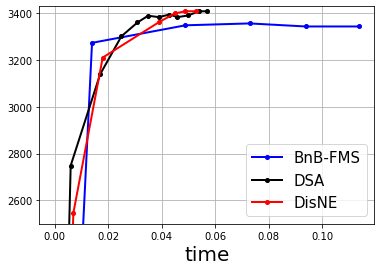

In [8]:
########### montonic function ##############

# plt.plot(BnBFMS_t, BnBFMS_u, 'b-', linewidth=2, color='blue', marker='D', fillstyle='none', markersize=8)
# plt.plot(dsa_t, dsa_u, 'b-', linewidth=2, color='black', marker='x', fillstyle='none', markersize=8)
# plt.plot(disNE_t, disNE_u, 'b-', linewidth=2, color='red', marker='o', fillstyle='none', markersize=8)
plt.plot(BnBFMS_t, BnBFMS_u, 'b-', linewidth=2, color='blue', marker='.', markersize=8)
plt.plot(dsa_t, dsa_u, 'b-', linewidth=2, color='black', marker='.', markersize=8)
plt.plot(disNE_t, disNE_u, 'b-', linewidth=2, color='red', marker='.', markersize=8)
# plt.plot(BnBFMS_t, BnBFMS_u, 'b-', linewidth=2, color='blue', fillstyle='none', markersize=8)
# plt.plot(dsa_t, dsa_u, 'b-', linewidth=2, color='black', fillstyle='none', markersize=8)
# plt.plot(disNE_t, disNE_u, 'b-', linewidth=2, color='red', fillstyle='none', markersize=8)
plt.grid()
plt.ylim(2500,3430)
plt.legend(['BnB-FMS', 'DSA', 'DisNE'], fontsize=15)
# plt.ylabel('utility', fontsize=20)
plt.xlabel('time', fontsize=20)
# plt.tick_params(labelsize=18)
plt.savefig('mono_cap_u.pdf',bbox_inches='tight')
# plt.show()
##




[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
DisNE:  2234
DSA:  1328


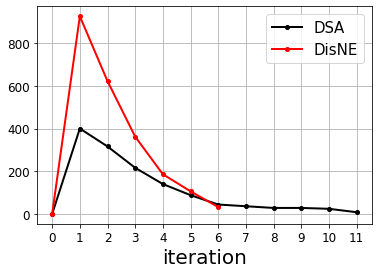

In [27]:
# plt.figure()

plt.plot(list(range(0, len(dsa_msg))), dsa_msg, 'b-', linewidth=2, color='black', marker='.', markersize=8)
plt.plot(list(range(0, len(DisNE_msg))), DisNE_msg, 'b-', linewidth=2, color='red', marker='.', markersize=8)
plt.grid()
plt.legend(['DSA', 'DisNE'], fontsize=15)
plt.xlabel('iteration', fontsize=20)
x = list(range(0, len(dsa_msg)))
print(x)
index_ls = ['0','1', '2', '3', '4', '5','6', '7', '8', '9', '10', '11']
_ = plt.xticks(x,index_ls)  ##  plt.xticks([])
plt.tick_params(labelsize=12)
plt.savefig('mono_cap_message.pdf',bbox_inches='tight')
# plt.show()
print('DisNE: ', sum(DisNE_msg))
print('DSA: ', sum(dsa_msg))
##

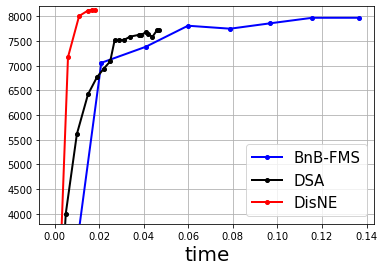

In [12]:
########### random function ##############

# plt.plot(BnBFMS_t, BnBFMS_u, 'b-', linewidth=2, color='blue', marker='D', fillstyle='none', markersize=8)
# plt.plot(dsa_t, dsa_u, 'b-', linewidth=2, color='black', marker='x', fillstyle='none', markersize=8)
# plt.plot(disNE_t, disNE_u, 'b-', linewidth=2, color='red', marker='o', fillstyle='none', markersize=8)
plt.plot(BnBFMS_t, BnBFMS_u, 'b-', linewidth=2, color='blue', marker='.', markersize=8)
plt.plot(dsa_t, dsa_u, 'b-', linewidth=2, color='black', marker='.', markersize=8)
plt.plot(disNE_t, disNE_u, 'b-', linewidth=2, color='red', marker='.', markersize=8)
# plt.plot(BnBFMS_t, BnBFMS_u, 'b-', linewidth=2, color='blue', fillstyle='none', markersize=8)
# plt.plot(dsa_t, dsa_u, 'b-', linewidth=2, color='black', fillstyle='none', markersize=8)
# plt.plot(disNE_t, disNE_u, 'b-', linewidth=2, color='red', fillstyle='none', markersize=8)
plt.grid()
plt.ylim(3800,8200)
plt.legend(['BnB-FMS', 'DSA', 'DisNE'], fontsize=15)
# plt.ylabel('utility', fontsize=20)
plt.xlabel('time', fontsize=20)
# plt.tick_params(labelsize=18)
plt.savefig('mono_RF_u.pdf',bbox_inches='tight')
# plt.show()
##


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
DisNE:  1551
DSA:  1680


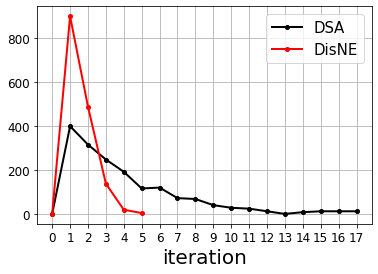

In [20]:
# plt.figure()

print(x)
plt.plot(list(range(0, len(dsa_msg))), dsa_msg, 'b-', linewidth=2, color='black', marker='.', markersize=8)
plt.plot(list(range(0, len(DisNE_msg))), DisNE_msg, 'b-', linewidth=2, color='red', marker='.', markersize=8)
plt.grid()
plt.legend(['DSA', 'DisNE'], fontsize=15)
# plt.ylabel('messages passed', fontsize=20)
plt.xlabel('iteration', fontsize=20)
x = list(range(0, len(dsa_msg)))
print(x)
index_ls = ['0','1', '2', '3', '4', '5','6', '7', '8', '9', '10', '11','12', '13', '14', '15','16','17']
_ = plt.xticks(x,index_ls)  ##  plt.xticks([])
plt.tick_params(labelsize=12)
plt.savefig('mono_RF_message.pdf',bbox_inches='tight')
# plt.show()
print('DisNE: ', sum(DisNE_msg))
print('DSA: ', sum(dsa_msg))